# Notes about simulation:

# Import packages and set settings

In [1]:
%matplotlib inline
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
# import math
import pandas as pd
from scipy.integrate import odeint
# from scipy.integrate import solve_ivp
import os
import itertools
from scipy.optimize import fsolve

In [2]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [10.0, 8.0]
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['legend.fontsize'] = 14
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]

In [3]:
# sns.palplot(sns.husl_palette(10, l=.7))
# palette_husl = sns.husl_palette(10, l=.7)
# sns.set_palette(palette_husl)
# # palette_husl.as_hex()
# rocket = sns.color_palette("rocket", 5)#[::-1][:4]
# rocket = rocket.as_hex()

In [4]:
MAPK_palette = {0:'#323232', 50000:'#D3D3D3', 150000:'#8ace88', 250000:'#5ab769', 350000: '#319a50', 450000:'#117b38', 550000:'#005723'}
MAP2K_palette = {0:'#323232', 50000:'#D3D3D3', 150000:'#84bcdb', 250000:'#5ab769', 350000: '#319a50', 450000:'#117b38', 550000:'#084082'}
palettes = {0:MAPK_palette,
           1:MAP2K_palette,
           2:MAPK_palette,
           3:MAPK_palette,
           4:MAPK_palette }


# Supporting Functions

In [5]:
def molarity_conversion(molecules):
    Na = 6.02214076*10**23
    cell_volume = 44                                 # volume of a yeast cell
    return molecules/(Na*cell_volume*10**-15)*1000000 # returns uM

def gather_simulated_data(folder, gen, runs, top_plotting):
    mse = []
    params_from_file = []

    empty_data = 0
    for loaded_data in pathlib.Path(folder).glob('*.pickled'):
        if os.path.getsize(loaded_data) > 0:
            with open(loaded_data, 'rb') as f:
                new_data = pickle.load(f)
                mse.append(np.asarray(new_data[0]))
                params_from_file.append(np.asarray(new_data[1]))
        else:
            empty_data += 1

    top = round((runs-empty_data)*top_plotting)
    plt_top = round((runs-empty_data)*top_plotting)      

    new_params = []
    last_mses = []
    for i in range(len(params_from_file)):
        new_params.append(params_from_file[i][gen])
        last_mses.append(mse[i][gen])
    last_mses = np.asarray(last_mses)
#     last_mses = last_mses
    new_params = np.asarray(new_params)
    new_params = new_params.T

    idx_top = last_mses.argsort()[:top]

    top_params = [([new_params[i][x] for i in range(len(new_params))]) for x in idx_top]
    # top_params = []
    # for idx in idx_top:
    #     top_params.append(params_from_file[idx][100])

    print('Best MSE: ' + str(np.min([mse[idx][gen] for idx in idx_top])))
    print('Mean MSE of top 5%: ' + str(np.mean([mse[idx][gen] for idx in idx_top])))
    return idx_top, top_params, top, plt_top, new_params, params_from_file, mse, last_mses


    
def plt_mses_gen(gen,mse):
    plt.clf()
    fig, (ax3) = plt.subplots(1, 1, figsize=(12,8))
    colors2 = sns.color_palette("Greys", 20)[10:]
    pal2 = sns.set_palette(colors2)
    ax3.set_xlabel('Generation', fontsize=20)
    for idx in idx_top:
        ax3.semilogy([x for x in range(gen)], mse[idx][:gen])
    ax3.yaxis.grid(True)
    ax3.set_ylabel('SSE', fontsize=20)
    ax3.set_xlim([0,gen])
#     ax3.set_ylim([10**3,10**5])
    plt.show()
    

def plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M, colors=None):
    plt.rcParams['figure.figsize'] = [12.0, 8.0]

    if colors:
        pal3 = sns.set_palette(colors)

    with sns.axes_style("whitegrid"):
        plt.bar(range(0,len(labelnames)),height=diff,bottom=minimums,align='center',tick_label=labelnames, color='#DCDCDC',alpha = 0.5)
        x = sns.swarmplot(x='param',y='vals', data = df_top_params_log_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Parameters', fontsize=20)
        plt.ylabel('Learned parameter values (base 10)', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.show()
        

def plot_mses(labelnames, mses, top_p, colors, title):
    mses = [x.copy() for x in mses]
    top = len(mses[0])*top_p
    top_mses = [np.sort(x)[:int(top)] for x in mses]
    df_mses = pd.DataFrame(top_mses).T
    df_mses.columns = labelnames
    df_mses_M = df_mses.melt(var_name='model', value_name='vals')

    pal = sns.set_palette(colors)
    with sns.axes_style("whitegrid"):
        x = sns.swarmplot(x='model',y='vals', data = df_mses_M)
        x.set_xticklabels(labelnames,rotation=45)
    #     ax.set_yscale("log")
    #     ax.set_ylim(0.00001,100000)
    #     ax4.set_xticks(locs)
    #     plt.xticklabels(labelnames, fontsize=18, rotation=90)
        plt.xlabel('Models', fontsize=20)
        plt.ylabel('SMSE', fontsize=20)
    #     ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
        plt.title('SMSE of the top '+ str(int(top_p*100)) + '% of parameter sets')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/presentations/lab_meetings/Figures/"+title+".png",dpi=300)
#         plt.show()

# def get_synthdata(data, ):
    
def get_synth_data_params(opt_data_mapk,wt_data_synth,top_params,num):
    opt_tps = list(itertools.chain.from_iterable(opt_data_mapk.values()))
    smse = []
    for params in top_params[:num]:
        smse_total = 0
        #     arr_params_IP = convert_individual(learned_params, arr_conversion_matrix)

        for sig, tps, MAPK_wt_data in zip(list(opt_data_mapk.keys()), list(opt_data_mapk.values()), wt_data_synth):
            params_constants_sig = params_constants[:-1]+[sig]
            for fxn in [simulate_wt_experiment]:
                data = fxn(initals, params_constants_sig, params, tps)
                active = data[:,2]/params_constants[2]*100
        #         print(MAPK_wt_data, active)
                error_active = ((MAPK_wt_data - active)**2).mean()
                smse_total += error_active
                if sig == 550000:
                    data = fxn(initals, params_constants_sig, params, mapk_time)
                    map2k = data[:,1]/params_constants[1]*100
                    if any(x > 20 for x in map2k):
    #                     print(map2k)
                        continue
                    else:
                        smse_total += 5000
        smse.append(smse_total)
    idx_synth_param = sorted(range(len(smse)), key=lambda k: smse[k])
    return top_params[idx_synth_param[0]]


## Function to plot param behaviors

In [6]:
def plt_param_behaviors(top_params, plt_top, params_constants, initials, gen, doses, time, param, mapk_wt_data=None, mapk_t100a_data=None, mapk_time=None):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))


    # plot 1
#     title_text = 'Gen ' + str(gen) + ' best fits to WT'
    title_text = 'Wild-type MAPK Simulations'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time (min)', fontsize=16)
    ax1.set_ylabel('% ppHog1', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    palette = palettes.get(param)

    if mapk_wt_data:
        for sig, wt_data in zip(doses, mapk_wt_data):
            ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=palette.get(sig), label = str(int(sig/1000))+'mM KCl')
#     ax1.legend()

    # plot 2
#     title_text = 'Gen ' + str(gen) +  ' best fits to T100A + inhib'
    title_text = 'Inhibited MAPK Simulations'#'Best fits to kinase dead mutant dose data'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time (min)', fontsize=16)
    ax2.set_ylabel('% pppHog1', fontsize=16)

    if mapk_t100a_data:
        for sig, t100a_data in zip(doses, mapk_t100a_data):
#             print(len(t100a_data))
#             if sig == 0:
#                 continue
#                 print(mapk_time_t100a_long)
#                 ax2.plot(mapk_time_t100a_long, t100a_data, '^', mew=2, markersize=10, color=palette.get(sig))
#             else:
            ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=palette.get(sig))

#     ax2.legend(bbox_to_anchor=[1, 0.5], loc='center left')    

    # plot evolutionary algorithm data on plots 1 and 2:
#     print(params_constants[1])

    if param == 3:
        ax1.set_ylim(0,150)
        dt = 0.1
        steps = 5401
        time = np.linspace(0,dt*steps,steps)
    else:
        ax1.set_ylim(0,105)
        ax2.set_ylim(0,105)

    if params_constants[-1] == 0:
        ax1.set_ylim(50,105)

    for sig in doses:
        for params in top_params[:plt_top]:
#         for sig in doses:
            ss_data = run_ss(initials, params_constants, params)
            data = simulate_wt_experiment(ss_data, params_constants, sig, params, time)
            active = data[:,param]/params_constants[param]*100
#             print(data[:,param])
            ax1.plot(time, active, color=palette.get(sig))

#             if sig == 0: 
#                 time = np.linspace(0,300,3001)
#             else: 
#                 time = np.linspace(0,60,601)
            data = simulate_t100a_experiment(ss_data, params_constants, sig, params, time)
            active = data[:,param]/params_constants[param]*100
            ax2.plot(time, active, '--', color=palette.get(sig))

#     ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/Hog1.png",dpi=300,bbox_inches='tight')
    plt.show()
    
def plt_ramp_behaviors(top_params, plt_top, params_constants, initials, gen, time, param, hog1_ramp_data=None, mapk_ramp_time=None):
    fig, (ax1) = plt.subplots(1, 1, figsize=(9,4))
    
    ax1.plot(mapk_ramp_time, hog1_ramp_data[0], 'o', color='gray')
    
    for params in top_params[:plt_top]:
#         for sig in doses:
            ss_data = run_ss(initials, params_constants, params)
            data = simulate_ramp_experiment(ss_data, params_constants, params, time)
            active = data[:,param]/params_constants[param]*100
#             print(data[:,param])
            ax1.plot(time, active)
    plt.show()


In [7]:
def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
#     if t_step >= 40:
#         sig = 600000
    return sig
# plt.plot(time,[signal_ramp_special(x) for x in time])

## Function to plot param behaviors, diff consts

In [8]:
def plt_param_behaviors_consts_diff(top_params, plt_top, consts_diff, initials, gen, doses, time, param, mapk_wt_data=None, mapk_t100a_data=None, mapk_time=None):
    plt.clf()
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,4))


    # plot 1
#     title_text = 'Gen ' + str(gen) + ' best fits to WT'
    title_text = 'Wild-type MAPK Simulations'
    ax1.set_title(title_text, fontsize=20)
    ax1.set_xlabel('Time (min)', fontsize=16)
    ax1.set_ylabel('% ppHog1', fontsize=16)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14)
    palette = palettes.get(param)

    if mapk_wt_data:
        for sig, wt_data in zip(doses, mapk_wt_data):
            ax1.plot(mapk_time, wt_data, 'o', markersize=10, color=palette.get(sig), label = str(int(sig/1000))+'mM KCl')
#     ax1.legend()

    # plot 2
#     title_text = 'Gen ' + str(gen) +  ' best fits to T100A + inhib'
    title_text = 'Inhibited MAPK Simulations'#'Best fits to kinase dead mutant dose data'
    ax2.set_title(title_text, fontsize=20)
    ax2.set_xlabel('Time (min)', fontsize=16)
    ax2.set_ylabel('% pppHog1', fontsize=16)

    if mapk_t100a_data:
        for sig, t100a_data in zip(doses, mapk_t100a_data):
            ax2.plot(mapk_time, t100a_data, '^', mew=2, markersize=10, color=palette.get(sig))

    if param == 3:
        ax1.set_ylim(0,150)
        dt = 0.1
        steps = 5401
        time = np.linspace(0,dt*steps,steps)
    else:
        ax1.set_ylim(0,105)
        ax2.set_ylim(0,105)

#     if params_constants[-1] == 0:
#         ax1.set_ylim(50,105)

    for sig in doses:
        for params, params_constants in zip(top_params[:plt_top], consts_diff[:plt_top]):
#         for sig in doses:
            ss_data = run_ss(initials, params_constants, params)
            data = simulate_wt_experiment(ss_data, params_constants, sig, params, time)
            active = data[:,param]/params_constants[param]*100
#             print(data[:,param])
            ax1.plot(time, active, color=palette.get(sig))

#             if sig == 0: 
#                 time = np.linspace(0,300,3001)
#             else: 
#                 time = np.linspace(0,60,601)
            data = simulate_t100a_experiment(ss_data, params_constants, sig, params, time)
            active = data[:,param]/params_constants[param]*100
            ax2.plot(time, active, '--', color=palette.get(sig))

#     ax1.legend(bbox_to_anchor=[1, 0.5], loc='center left')
#     plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/Hog1.png",dpi=300,bbox_inches='tight')
    plt.show()

## Calculate score

In [87]:
params_constants[2]

0.22583331313564312

In [ ]:
# (b3_b2_a1_1D, inits, args=(0,total_protein, 0, learned_params))

0.22583331313564312
396.2120555939313
[0.0012196  0.15656223 0.22565822 0.22581832 0.22581833 0.22581833]


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


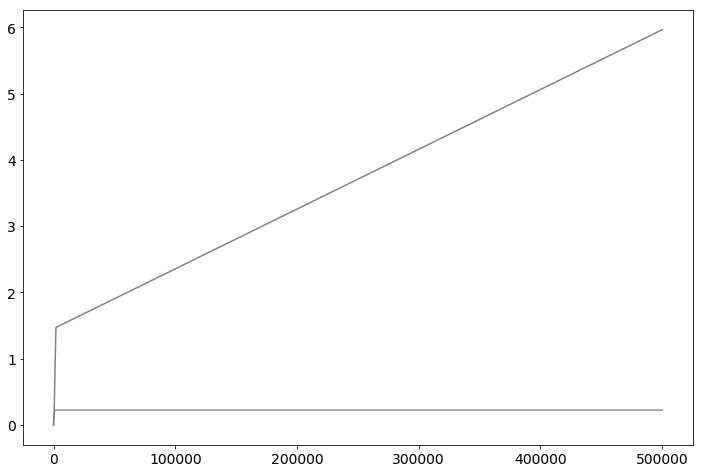

In [467]:
# wt_ss_inits = run_ss(initials, params_constants, test[3]) 
temp_time = [0,500,1000,1500,2000, 500000]
test2= odeint(b3_a1_1D, initials, temp_time, args=(params_constants, 0, test[3]))

test3= fsolve(b3_a1_1D, initials,  args=(temp_time, params_constants, 0, test[3]))

print(params_constants[2])
print(test3[2])
print(test2[:,2])
plt.plot(temp_time, test2[:,2])
plt.plot(temp_time, test2[:,3])

In [19]:
def scorefxn(inits, total_protein, params):
    mses = []
    exp_time = mapk_time
#     params = convert_individual(learned_params, arr_conversion_matrix, number_of_params)
    
    wt_ss_inits = run_ss(inits, total_protein, params) 
    check = total_protein-wt_ss_inits
    if (check < 0).any():
        return ((63+69+18*2+27)*100)**2

    ptpD_ss_inits = run_ss(inits, [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t*params[-1]], params)
    check = total_protein-ptpD_ss_inits
    if (check < 0).any():
        return ((63+69+18*2+27)*100)**2

    # wt hog1
    mse_total = 0
    for dose, data in zip(doses, mapk_wt_data): 
        odes = simulate_wt_experiment(wt_ss_inits, total_protein, dose, params, exp_time)
        mapk = odes[:,2]/total_protein[2]*100
        error_active = ((data - mapk)**2).mean()
        mse_total += error_active
#     mses.append(mse_total/63)
    mses.append(mse_total)
        
    # t100a hog1
    mse_total = 0
    for dose, data in zip(doses, mapk_t100a_data):
        if dose == 0:
            odes = simulate_t100a_experiment(wt_ss_inits, total_protein, dose, params, mapk_time_t100a_long)
            mapk = odes[:,2]/total_protein[2]*100
            error_active = ((mapk_data_t100a_long[0] - mapk)**2).mean()
            mse_total += error_active
            
        else:
            odes = simulate_t100a_experiment(wt_ss_inits, total_protein, dose, params, exp_time)
            mapk = odes[:,2]/total_protein[2]*100
            error_active = ((data - mapk)**2).mean()
            mse_total += error_active
    mses.append(mse_total)

    
    # wt pbs2
    mse_total = 0
    for dose, data in zip(map2k_doses, map2k_wt_data): 
        odes = simulate_wt_experiment(wt_ss_inits, total_protein, dose, params, exp_time)
        map2k = odes[:,1]/total_protein[1]*100
        error_active = ((data - map2k)**2).mean()
        mse_total += error_active
#     mses.append(mse_total/18)
    mses.append(mse_total)
    
#     t100a pbs2
    mse_total = 0
    for dose, data in zip(map2k_doses, map2k_t100a_data):  
        odes = simulate_t100a_experiment(wt_ss_inits, total_protein, dose, params, exp_time)
        map2k = odes[:,1]/total_protein[1]*100
        error_active = ((data - map2k)**2).mean()
        mse_total += error_active
#     mses.append(mse_total/18)
    mses.append(mse_total)
    
    # ramp
    mse_total = 0
    for data in hog1_ramp_data:   
        odes = simulate_ramp_experiment(wt_ss_inits, total_protein, params, mapk_ramp_time)
        mapk = odes[:,2]/total_protein[2]*100
        error_active = ((data - mapk)**2).mean()
        mse_total += error_active
#     mses.append(mse_total/13)
    mses.append(mse_total)

    # for ptpDs
    mse_total = 0
    for dose, data in zip(ptp_doses, mapk_ptp_data):      
        odes = simulate_wt_experiment(ptpD_ss_inits, [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t*params[-1]], dose, params, exp_time)
        mapk = odes[:,2]/total_protein[2]*100
        error_active = ((data - mapk)**2).mean()
        mse_total += error_active
#     mses.append(mse_total/27)
    mses.append(mse_total)
    
    return mses

# Load data to fit to

In [10]:
wt_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/WT'
t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/T100A'
pbs2_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2'
pbs2_t100a_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/Pbs2_T100A'
# sho1DD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/sho1DD'
# ssk1D_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ssk1D'
hog1_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ramp_1'
# pbs2_ramp_folder =  'C:/Users/sksuzuki/Desktop/killdevil/data_pbs2/MAPK activation/pulse_pbs2'
ptpD_folder = 'C:/Users/sksuzuki/Desktop/killdevil/data/MAPK activation/ptpD'

def load_csv_data(folder):
    data = []
    for csv in pathlib.Path(folder).glob('*.csv'):
        f_data = pd.read_csv(csv)
        time = f_data['Time'].tolist()
        f_data=f_data.set_index('Time')
        f_data = f_data.mean(axis=1)
        f_data = f_data.tolist()
        data.append(f_data)
    return time, data

mapk_time, mapk_wt_data = load_csv_data(wt_folder)
mapk_time, mapk_t100a_data = load_csv_data(t100a_folder)
mapk_data_t100a_long = [mapk_t100a_data[0]] 
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

mapk_time, map2k_wt_data = load_csv_data(pbs2_folder)
mapk_time, map2k_t100a_data = load_csv_data(pbs2_t100a_folder)
mapk_time, mapk_ptp_data = load_csv_data(ptpD_folder)
# mapk_time, sho1_wt_data = load_csv_data(ssk1D_folder)
# mapk_time, sln1_wt_data = load_csv_data(sho1DD_folder)
mapk_ramp_time, hog1_ramp_data = load_csv_data(hog1_ramp_folder)
# mapk_pulse_time, pbs2_pulse_data = load_csv_data(pbs2_pulse_folder)

# hog1_pulse_data = hog1_pulse_data[0]
# pbs2_pulse_data = pbs2_pulse_data[0]


# scorefxn_data = [mapk_wt_data, mapk_t100a_data, map2k_wt_data, map2k_t100a_data, hog1_ramp_data]
# scorefxn_time = [mapk_time,mapk_ramp_time]

In [11]:
# exclude far points
mapk_t100a_data = [mapk_t100a_data[0][:9]] + mapk_t100a_data[1:]


In [20]:
dt = 0.1
steps = 601
time = np.linspace(0,dt*steps,steps)

# idx_closest_time_points = get_closest_tps(mapk_time,time)

# Mutual inhibition

##  A1: ptp total 100 - kb - full - 0 fit to PTPD data - not ramp  - 2 negative feedbacks

**Notes** 


### Inputs

In [61]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/runs_for_paper/190627_ptpFIT_1D_b3_b2/'
gen = 1000
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
PTP = molarity_conversion(118)

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118)

# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['beta_3', 'beta_2', 'alpha_1', 'alpha_2', 'kb', 'k1', 'k3', 'k5', 's7', 'k9', 'k2', 'k4', 'k6', 'd8', 'K_1', 'K_3', 'K_5', 'K_9', 'K_2', 'K_4', 'K_6', 'K_10'
                ] #21

minimums = [-4, -4, -4, 0,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -4, -4]

maximums = [ 4, 4, 4, 8, 
    4, 4, 4, 4, 4,
    4, 4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, X, PTP]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t] 
doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_doses = [150000, 550000]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly','PTP']

In [64]:
def b3_b2_a1_1D(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_3, beta_2, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - ((k2+beta_2*MAPK)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP

def run_wt_ss(inits, total_protein, learned_params):
    ss = fsolve(b3_b2_a1_1D, inits, args=(0,total_protein, 0, learned_params))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    odes = odeint(b3_b2_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes

def b3_b2_a1_1D_ramp(initials,t,total_protein,params):
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_3, beta_2, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    sig = signal_ramp_special(t)

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - ((k2+beta_2*MAPK)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP


def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    beta_3, beta_2, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
    learned_params = beta_3, 0, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
    #solve odes:
    odes = odeint(b3_b2_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes

# def simulate_nopos_experiment(inits, total_protein, sig, learned_params, time):
#     # parameters to be learned - inits
#     # parameters to be kept constant - params_constants
#     # parameters to be learned - learned_params
#     beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
#     learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
#     #solve odes:
#     odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
#     return odes


def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_b2_a1_1D_ramp, inits, time, args=(total_protein, learned_params))
    return odes

def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
    return sig

In [62]:
def run_ss(inits, total_protein, learned_params):
    ss = fsolve(b3_b2_a1_1D, inits, args=(0,total_protein, 0, learned_params))#/total_protein*100
    return ss

# def run_t100a_ss(inits, total_protein, learned_params):
#     beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
#     learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
#     ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
#     return ss

### Gather simulated data

In [63]:
idx_top, top_params_a1_1D, top, plt_top, new_params, params_from_file, mse_a1_1D, last_mses_a1_1D = gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_a1_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 1715.1097000251436
Mean MSE of top 5%: 1973.071366949315


### Plot

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 864x576 with 0 Axes>

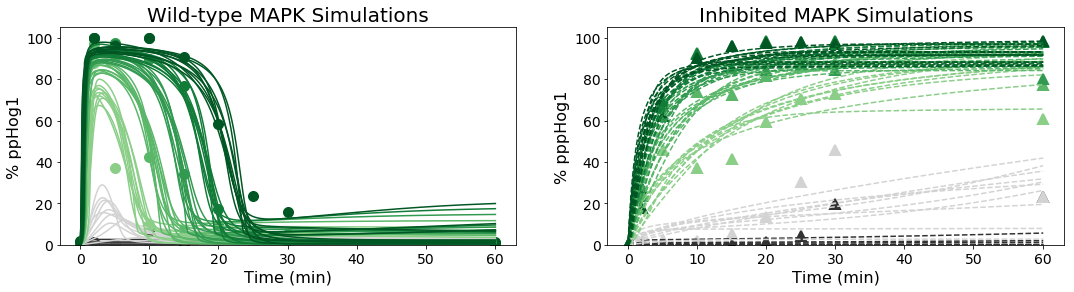

In [65]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 720x576 with 0 Axes>

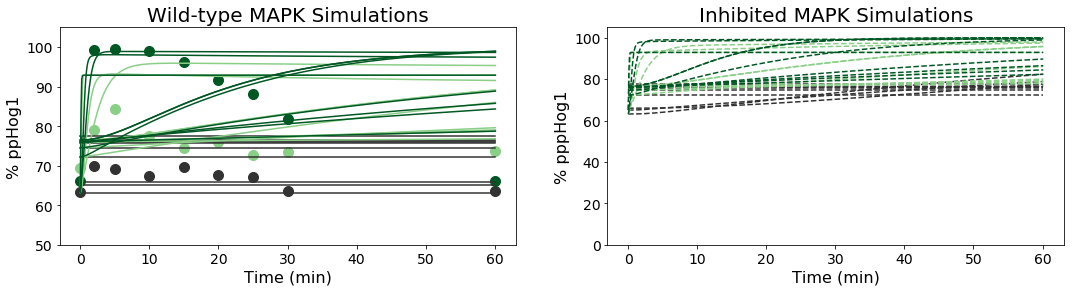

In [22]:
plt_param_behaviors(top_params_a1_1D, 10, [MAP3K_t, MAP2K_t, MAPK_t, 1, 0], initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

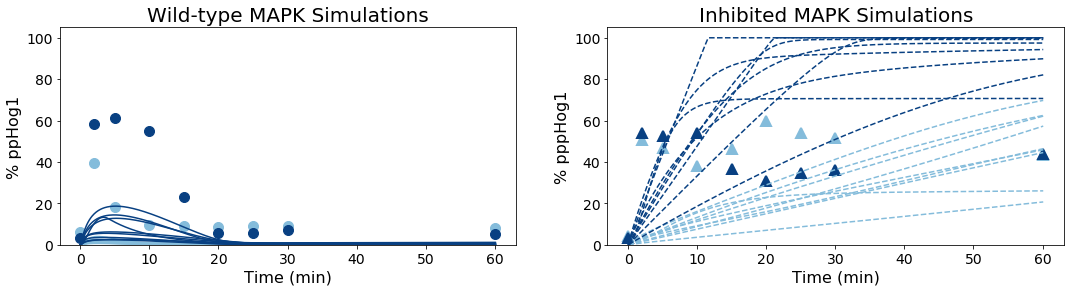

In [23]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

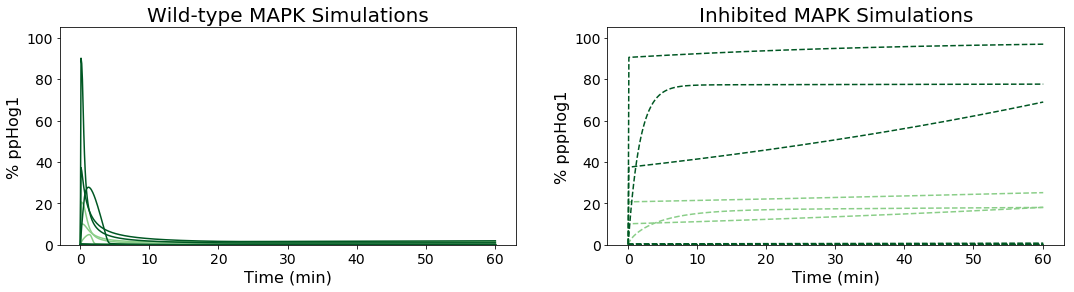

In [24]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 0)

In [ ]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 3)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

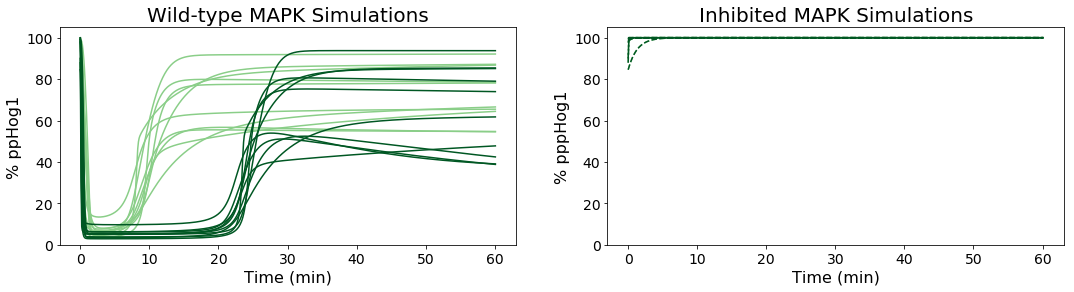

In [25]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


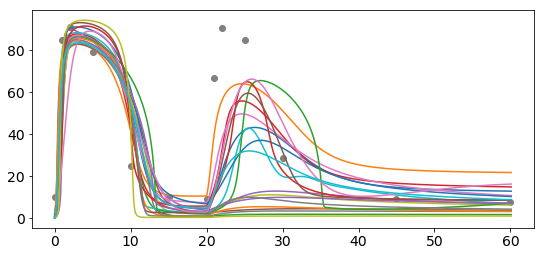

In [26]:
plt_ramp_behaviors(top_params_a1_1D, plt_top, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 720x576 with 0 Axes>

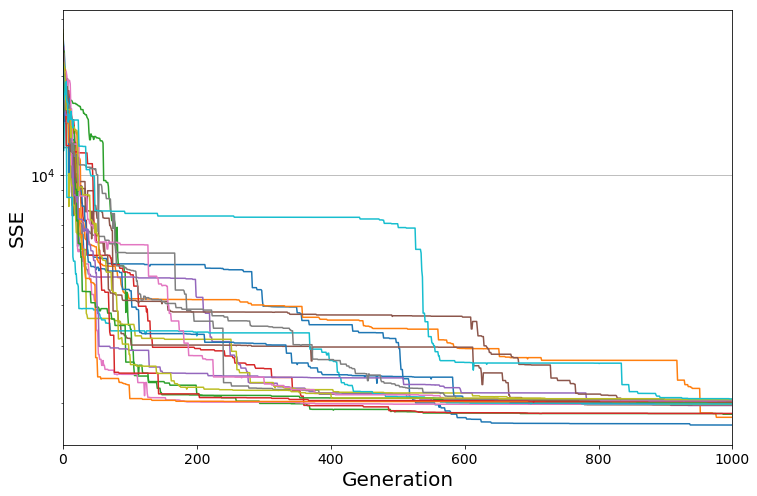

In [27]:
plt_mses_gen(gen,mse_a1_1D)

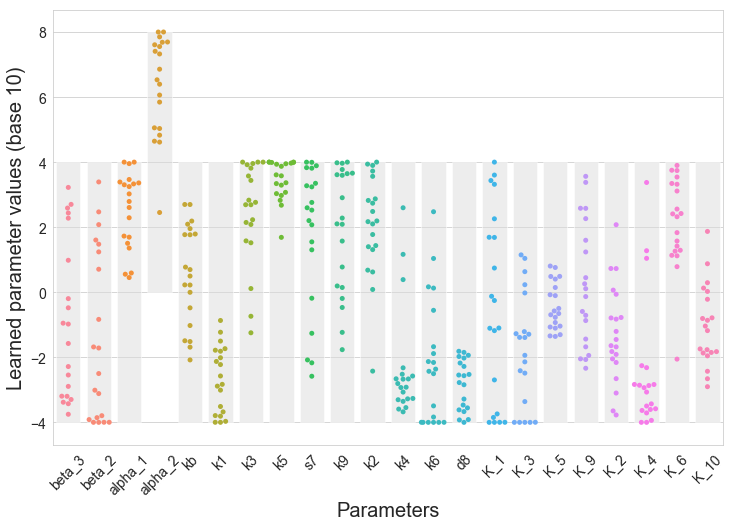

In [52]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c','#3c3c3c']*7 #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

##  ptpFIT_190704.py -  no negative feedback, just mututal inhibition

**Notes** 


### Inputs

In [110]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190704_justPTP/'
gen = 1000
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
PTP = molarity_conversion(118)

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118)

# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['alpha_1', 'alpha_2', 'kb', 'k1', 'k3', 'k5', 'k9', 'k2', 'k4', 'k6', 'K_1', 'K_3', 'K_5', 'K_9', 'K_2', 'K_4', 'K_6', 'K_10'
                ]

minimums = [
    -4, -4, -4, -4,-4, -4,
    -4, -4, -4, -4,
    -4, -4, -4,-4,
    -4, -4, -4,-4]

maximums = [ 
    4, 4, 4, 4,4, 4,
    4, 4, 4, 4,
    4, 4, 4,4,
    4, 4, 4,4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, PTP]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t] 
doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_doses = [150000, 550000]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly','PTP']

In [97]:
if len(labelnames) == len(diff):
    print('Params and labels match')
else:
    print(len(labelnames))
    print(len(diff))

Params and labels match


In [114]:
def a1_1D(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    alpha_1, alpha_2, kb, k1, k3, k5, k9, k2, k4, k6, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = params #18

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1+kb))*MAP3K_I)/(K_1+MAP3K_I) - ((k2)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dPTP

def run_wt_ss(inits, total_protein, learned_params):
    ss = fsolve(a1_1D, inits, args=(0,total_protein, 0, learned_params))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    odes = odeint(a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes

def a1_1D_ramp(initials,t,total_protein,params):
    MAP3K, MAP2K, MAPK, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    alpha_1, alpha_2, kb, k1, k3, k5, k9, k2, k4, k6, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = params #18

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    sig = signal_ramp_special(t)

    dMAP3K = ((sig*k1+kb)*MAP3K_I)/(K_1+MAP3K_I) - ((k2)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dPTP


def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    alpha_1, alpha_2, kb, k1, k3, k5, k9, k2, k4, k6, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
    learned_params = 0, alpha_2, kb, k1, k3, k5, k9, k2, k4, k6, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
    #solve odes:
    odes = odeint(a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes

# def simulate_nopos_experiment(inits, total_protein, sig, learned_params, time):
#     # parameters to be learned - inits
#     # parameters to be kept constant - params_constants
#     # parameters to be learned - learned_params
#     beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
#     learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
#     #solve odes:
#     odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
#     return odes


def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(a1_1D_ramp, inits, time, args=(total_protein, learned_params))
    return odes

def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
    return sig

In [106]:
def run_ss(inits, total_protein, learned_params):
    ss = fsolve(a1_1D, inits, args=(0,total_protein, 0, learned_params))#/total_protein*100
    return ss

# def run_t100a_ss(inits, total_protein, learned_params):
#     beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
#     learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
#     ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
#     return ss

### Gather simulated data

In [115]:
idx_top, top_params_a1_1D, top, plt_top, new_params, params_from_file, mse_a1_1D, last_mses_a1_1D = gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_a1_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 9592.360725860592
Mean MSE of top 5%: 11161.101059300681


### Plot

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 720x576 with 0 Axes>

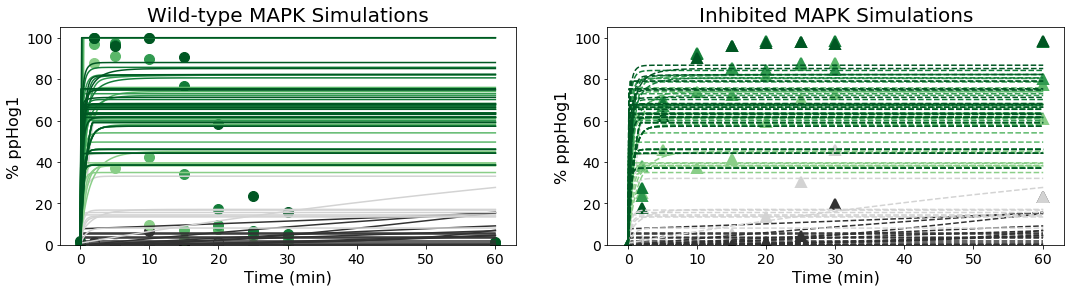

In [116]:
plt_param_behaviors(top_params_a1_1D, 20, params_constants, initials, 1000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

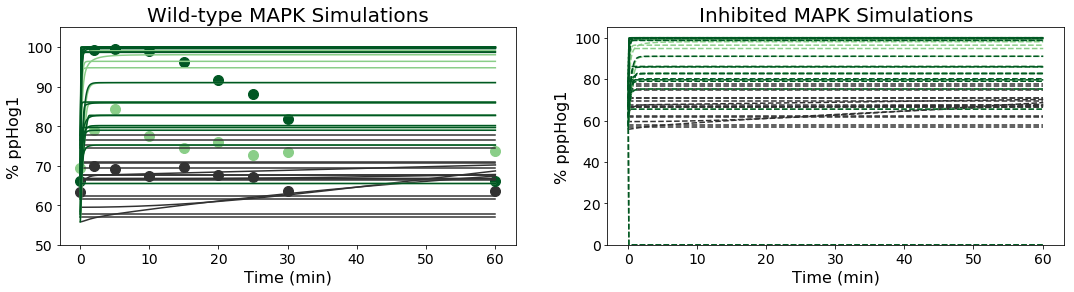

In [117]:
plt_param_behaviors(top_params_a1_1D, 20, [MAP3K_t, MAP2K_t, MAPK_t, 1, 0], initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

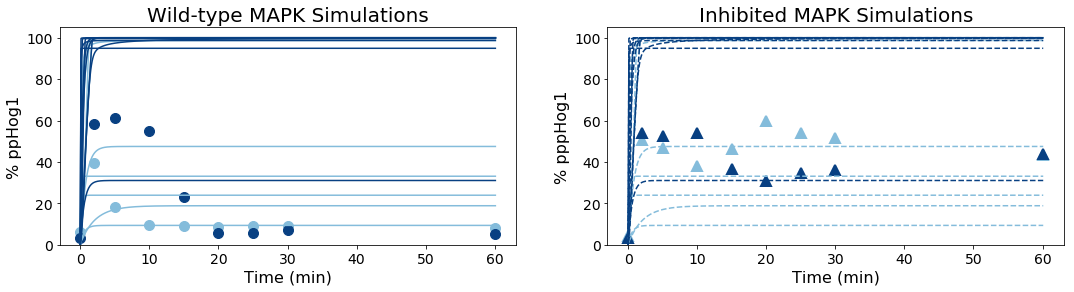

In [118]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

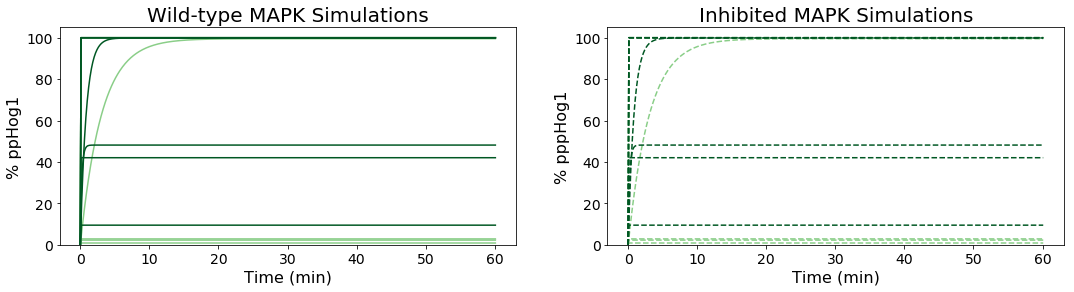

In [119]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 0)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

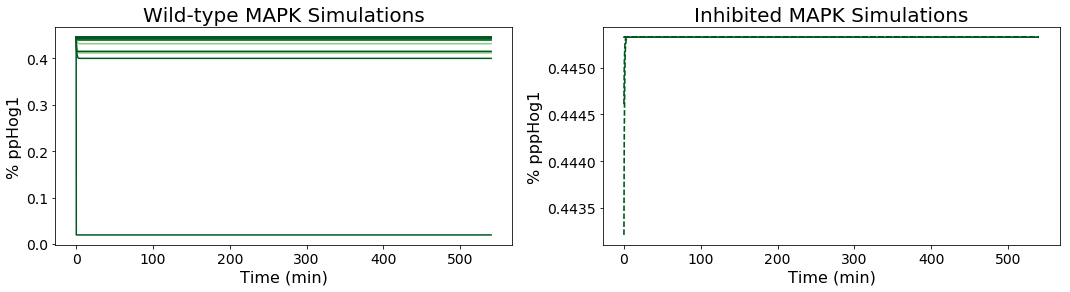

In [120]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 3)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

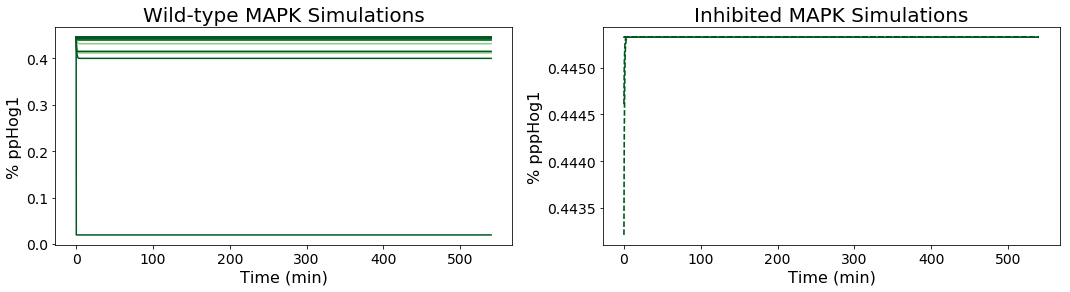

In [122]:
# plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


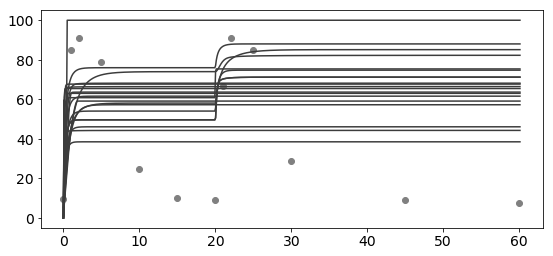

In [123]:
plt_ramp_behaviors(top_params_a1_1D, plt_top, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 720x576 with 0 Axes>

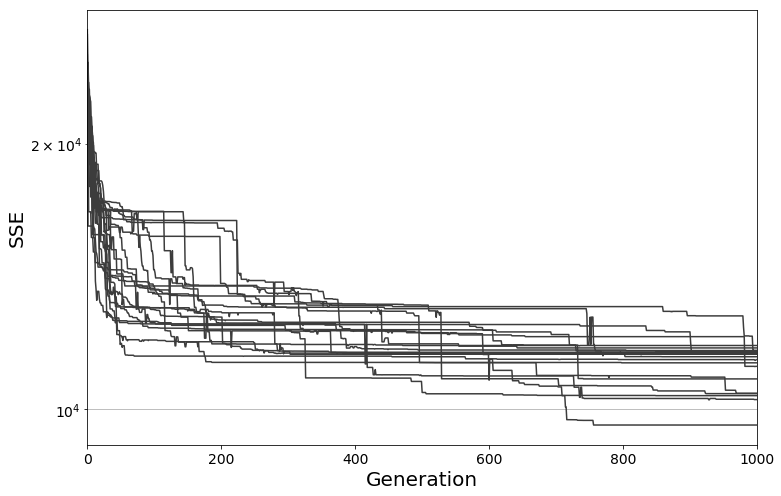

In [124]:
plt_mses_gen(gen,mse_a1_1D)

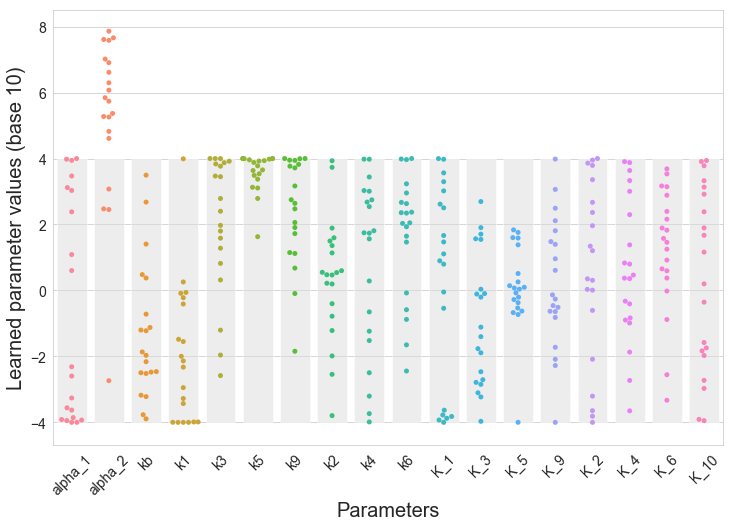

In [125]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

##  190705_basal_synth.py -  same model with X species with 0 order synth term

**Notes** 


### Inputs

In [12]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190705_basal_synth/'
gen = 1000
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
PTP = molarity_conversion(118)

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118)

# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['beta_3', 'alpha_1', 'alpha_2', 'kb', 'k1', 'k3', 'k5', 's6', 's7', 'k9', 'k2', 'k4', 'k6', 'd8', 'K_1', 'K_3', 'K_5', 'K_9', 'K_2', 'K_4', 'K_6', 'K_10' #22

                ]

minimums = [-4, -4, -4,
    -4, -4, -4, -4, -4, -4,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -4, -4]

maximums = [ 4, 4, 8,
    4, 4, 4, 4, 4, 4,
    4, 4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 4, 4]


diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, X, PTP]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t] 
doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_doses = [150000, 550000]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly','PTP']

In [13]:
if len(labelnames) == len(diff):
    print('Params and labels match')

Params and labels match


In [14]:
def b3_a1_1D(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s6, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s6 + s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP

def run_wt_ss(inits, total_protein, learned_params):
    ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes


def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s6, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
    learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, s6, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
    #solve odes:
    odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes

def b3_a1_1D_ramp(initials, t, total_protein, params):
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s6, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    sig = signal_ramp_special(t)
    
    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s6 + s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP

def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a1_1D_ramp, inits, time, args=(total_protein, learned_params))
    return odes

def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
    return sig

In [15]:
def run_ss(inits, total_protein, learned_params):
    ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))#/total_protein*100
    return ss

# def run_t100a_ss(inits, total_protein, learned_params):
#     beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
#     learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
#     ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
#     return ss

### Gather simulated data

In [19]:
idx_top, top_params_a1_1D, top, plt_top, new_params, params_from_file, mse_a1_1D, last_mses_a1_1D = gather_simulated_data(folder, gen, runs, 0.5)
df_top_params = pd.DataFrame(top_params_a1_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 1971.8484550624594
Mean MSE of top 5%: 4939.375673043916


### Plot

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

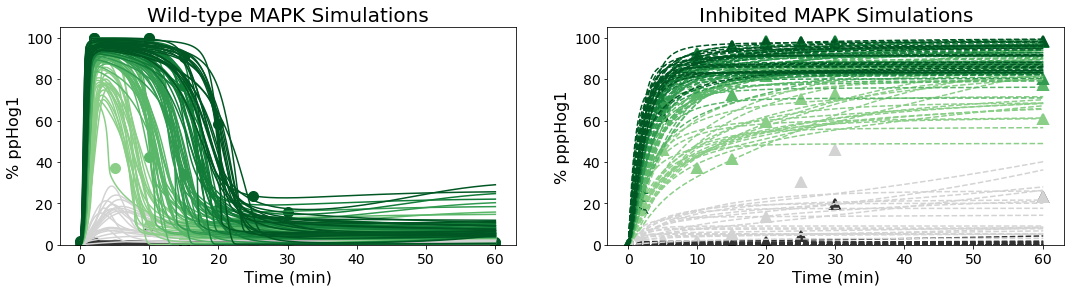

In [17]:
plt_param_behaviors(top_params_a1_1D, 20, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 720x576 with 0 Axes>

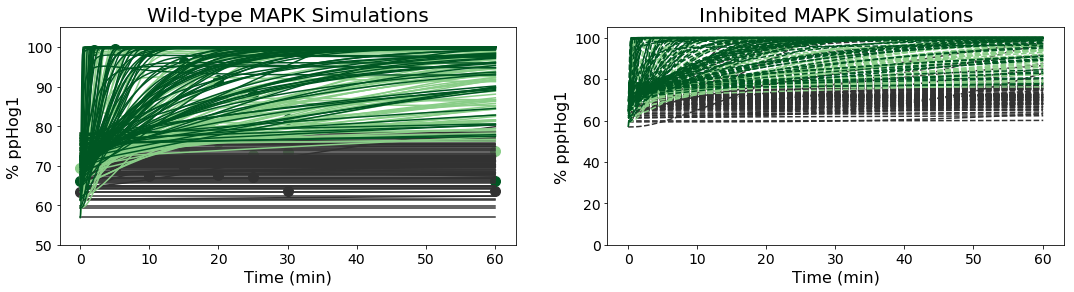

In [23]:
plt_param_behaviors(top_params_a1_1D, 100, [MAP3K_t, MAP2K_t, MAPK_t, 1, 0], initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

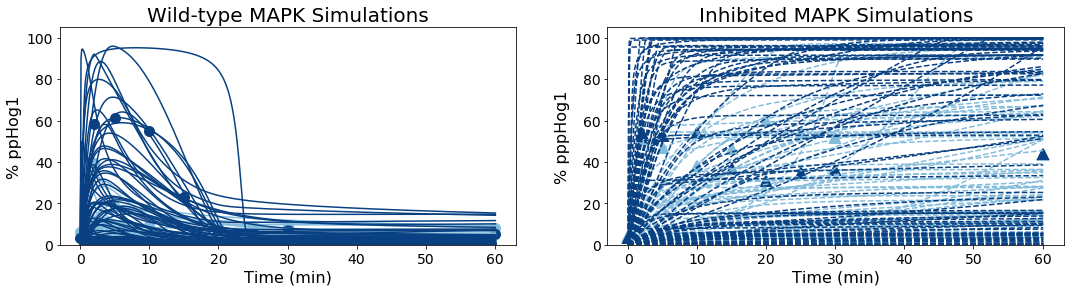

In [22]:
plt_param_behaviors(top_params_a1_1D, 100, params_constants, initials, 5000, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 864x576 with 0 Axes>

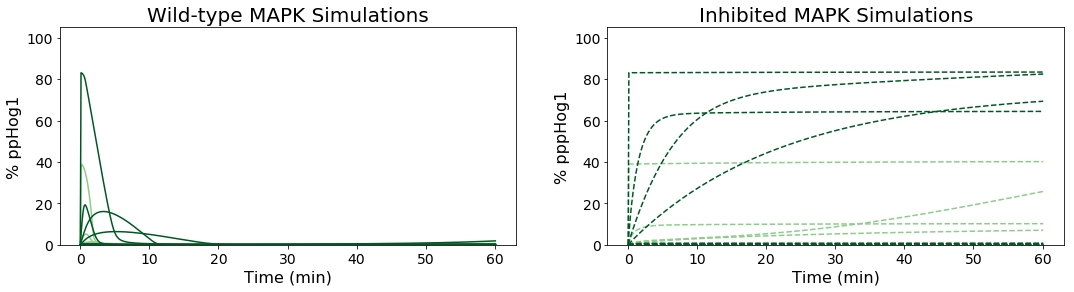

In [135]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 0)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 864x576 with 0 Axes>

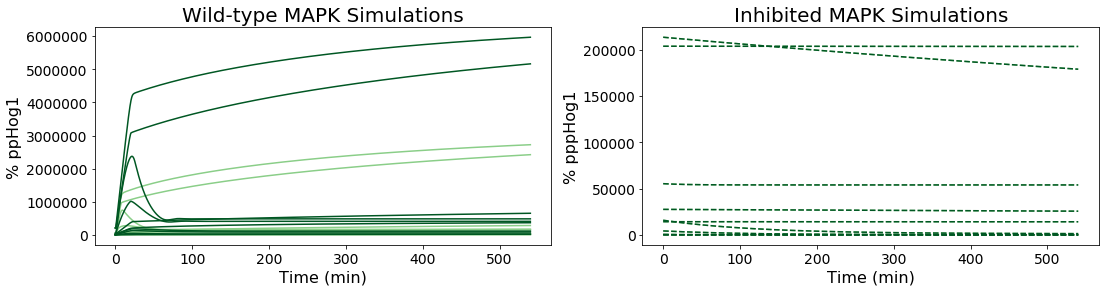

In [136]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 3)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 864x576 with 0 Axes>

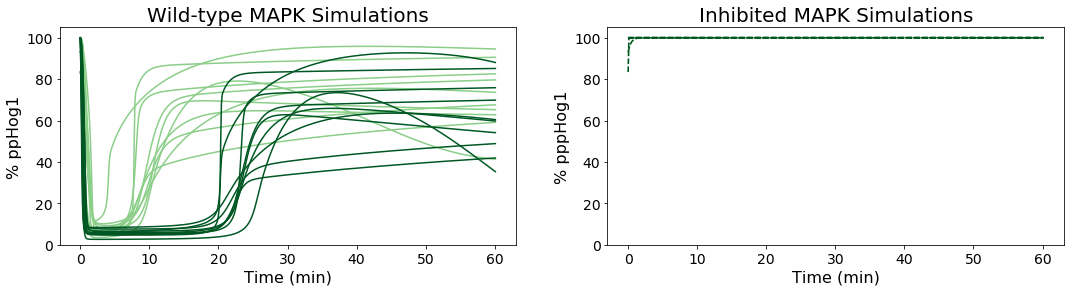

In [140]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


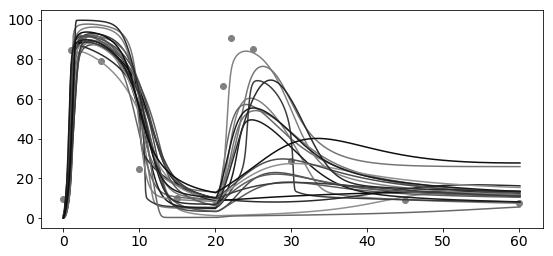

In [147]:
plt_ramp_behaviors(top_params_a1_1D, plt_top, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 864x576 with 0 Axes>

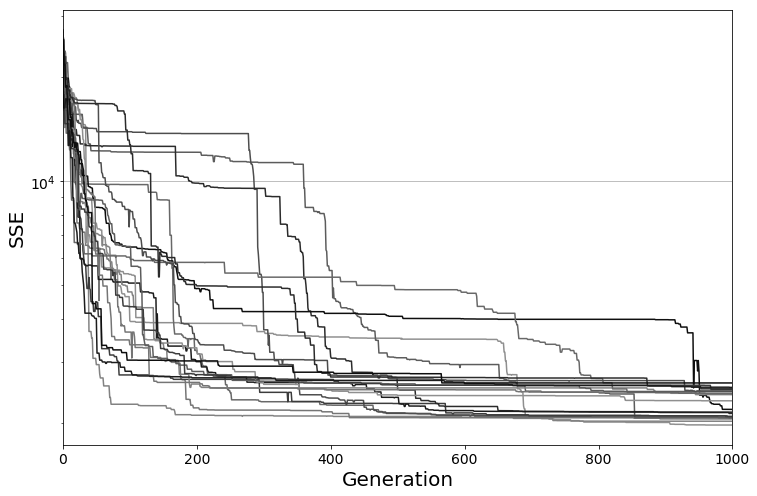

In [148]:
plt_mses_gen(gen,mse_a1_1D)

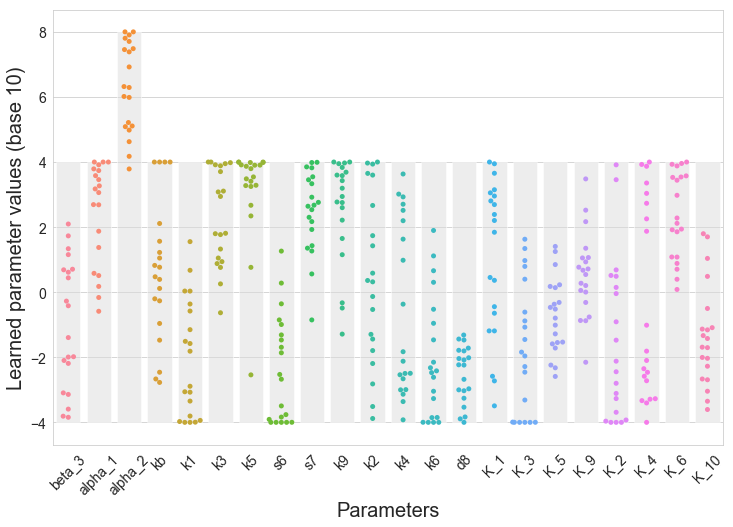

In [149]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

##  190705_ptp_ptc.py -  two mutual inhibitions steps, no negative feedback

**Notes** 


### Inputs

In [150]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190705_ptp_ptc/'
gen = 1000
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
PTC = molarity_conversion(400)
PTP = molarity_conversion(118)

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTC_t = molarity_conversion(400)
PTP_t = molarity_conversion(118)

# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = [    'alpha_1', 'alpha_2', 'alpha_3', 'alpha_4', 'kb', 'k1', 'k3', 'k5', 'k7', 'k9', 'k2', 'k4', 'k6', 'K_1', 'K_3', 'K_5', 'K_7', 'K_9', 'K_2', 'K_4', 'K_6', 'K_8', 'K_10' #23
                ]

minimums = [-4, -4, -4, -4,
    -4, -4, -4, -4, -4, -4,
    -4, -4, -4,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4, -4]

maximums = [ 4, 8, 4, 4,
    4, 4, 4, 4, 4, 4,
    4, 4, 4,
    4, 4, 4, 4, 4,
    4, 4, 4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, PTC, PTP]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTC_t, PTP_t] 
doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_doses = [150000, 550000]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly','PTP']

In [151]:
if len(labelnames) == len(diff):
    print('Params and labels match')

Params and labels match


In [164]:
def ptp_ptc(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, PTC, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, PTC_t, PTP_t = total_protein
    alpha_1, alpha_2, alpha_3, alpha_4, kb, k1, k3, k5, k7, k9, k2, k4, k6, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10 = params #23

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTC_I = PTC_t-PTC
    PTP_I = PTP_t-PTP

    # dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - ((k2)*MAP3K/(K_2+MAP3K))
    dMAP3K = ((sig*k1+kb)*MAP3K_I)/(K_1+MAP3K_I) - ((k2)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP+alpha_4*PTC)*MAPK)/(K_6+MAPK)
    # dgly = s7*MAPK - d8*gly
    dPTC = (k7*PTC_I/(K_7+PTC_I)) - ((alpha_3*MAPK)*PTC)/(K_8+PTC)
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)


    return dMAP3K, dMAP2K, dMAPK, dPTC, dPTP

def run_wt_ss(inits, total_protein, learned_params):
    ss = fsolve(ptp_ptc, inits, args=(0,total_protein, 0, learned_params))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    odes = odeint(ptp_ptc, inits, time, args=(total_protein, sig, learned_params))
    return odes

def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    alpha_1, alpha_2, alpha_3, alpha_4, kb, k1, k3, k5, k7, k9, k2, k4, k6, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10 = learned_params #23
    learned_params = 0, alpha_2, 0, alpha_4, kb, k1, k3, k5, k7, k9, k2, k4, k6, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10 #23

    #solve odes:
    odes = odeint(ptp_ptc, inits, time, args=(total_protein, sig, learned_params))
    return odes


def b3_b2_a1_1D_ramp(initials,t,total_protein,params):
    MAP3K, MAP2K, MAPK, PTC, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, PTC_t, PTP_t = total_protein
    alpha_1, alpha_2, alpha_3, alpha_4, kb, k1, k3, k5, k7, k9, k2, k4, k6, K_1, K_3, K_5, K_7, K_9, K_2, K_4, K_6, K_8, K_10 = params #23

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTC_I = PTC_t-PTC
    PTP_I = PTP_t-PTP
    
    sig = signal_ramp_special(t)
    
    # dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - ((k2)*MAP3K/(K_2+MAP3K))
    dMAP3K = ((sig*k1+kb)*MAP3K_I)/(K_1+MAP3K_I) - ((k2)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP+alpha_4*PTC)*MAPK)/(K_6+MAPK)
    # dgly = s7*MAPK - d8*gly
    dPTC = (k7*PTC_I/(K_7+PTC_I)) - ((alpha_3*MAPK)*PTC)/(K_8+PTC)
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dPTC, dPTP

def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_b2_a1_1D_ramp, inits, time, args=(total_protein, learned_params))
    return odes


def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
    return sig

In [154]:
def run_ss(inits, total_protein, learned_params):
    ss = fsolve(ptp_ptc, inits, args=(0,total_protein, 0, learned_params))#/total_protein*100
    return ss

# def run_t100a_ss(inits, total_protein, learned_params):
#     beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
#     learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
#     ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
#     return ss

### Gather simulated data

In [155]:
idx_top, top_params_a1_1D, top, plt_top, new_params, params_from_file, mse_a1_1D, last_mses_a1_1D = gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_a1_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 9470.27893876658
Mean MSE of top 5%: 11316.312230995027


### Plot

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 864x576 with 0 Axes>

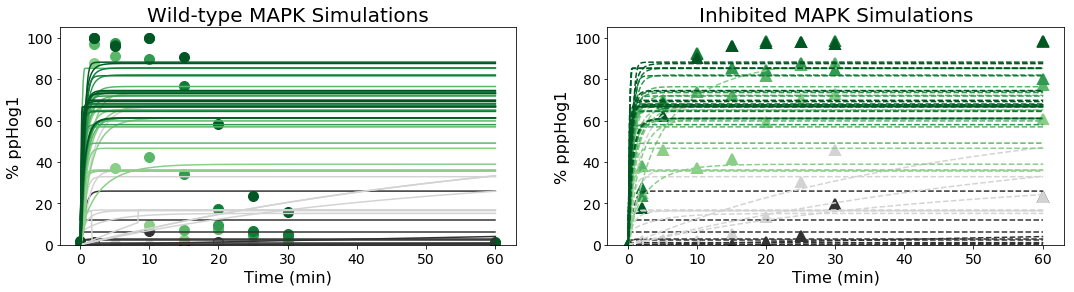

In [157]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 864x576 with 0 Axes>

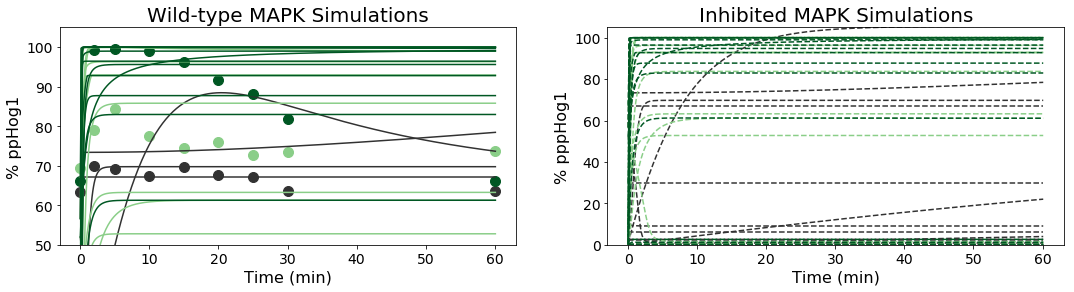

In [158]:
plt_param_behaviors(top_params_a1_1D, 20, [MAP3K_t, MAP2K_t, MAPK_t, 1, 0], initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 864x576 with 0 Axes>

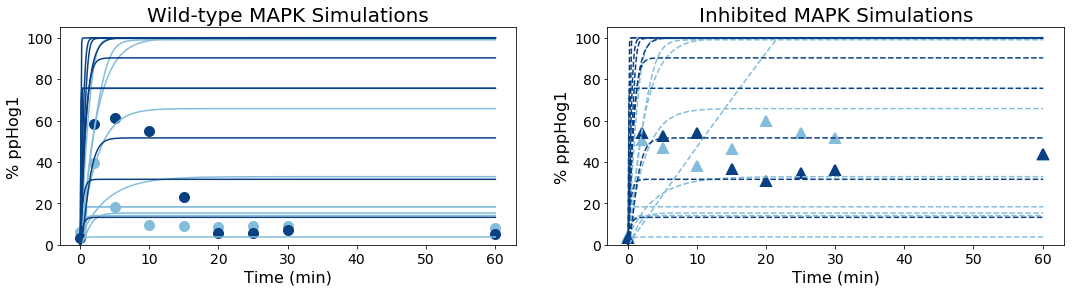

In [159]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 864x576 with 0 Axes>

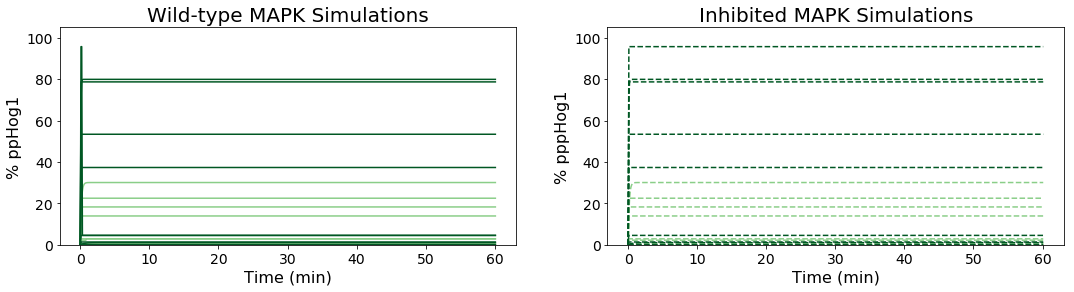

In [160]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 0)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 864x576 with 0 Axes>

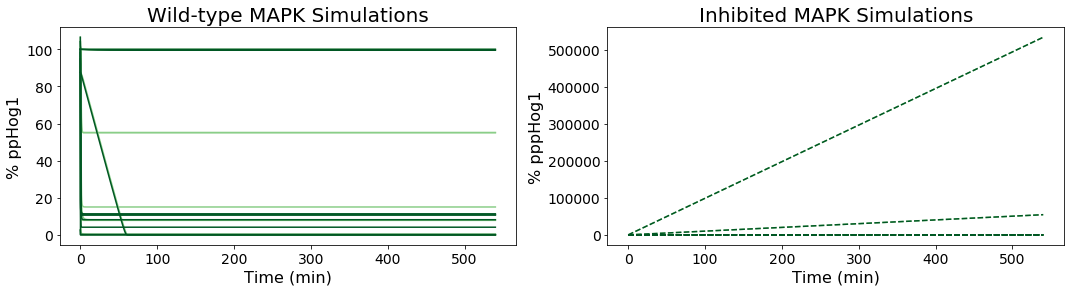

In [161]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 3)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 864x576 with 0 Axes>

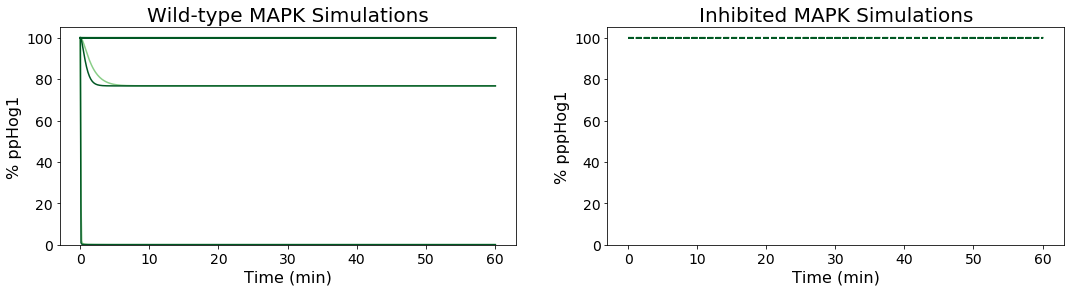

In [162]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


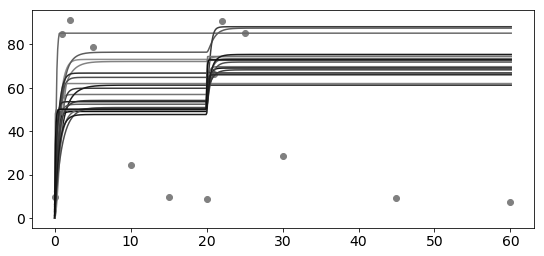

In [165]:
plt_ramp_behaviors(top_params_a1_1D, plt_top, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 864x576 with 0 Axes>

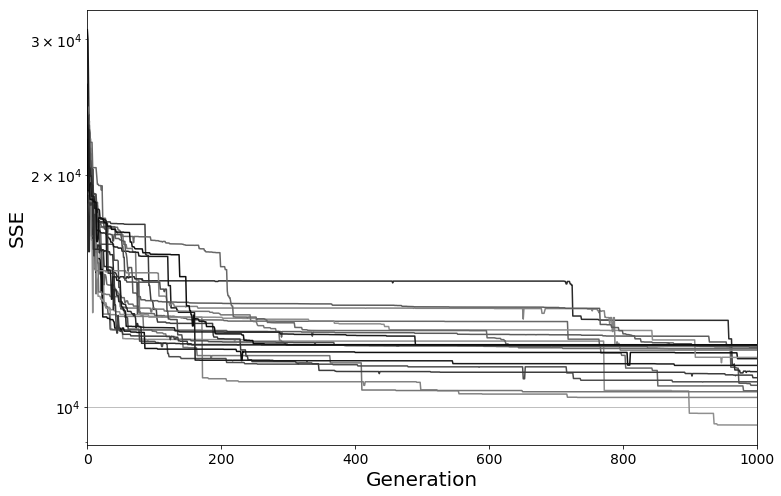

In [166]:
plt_mses_gen(gen,mse_a1_1D)

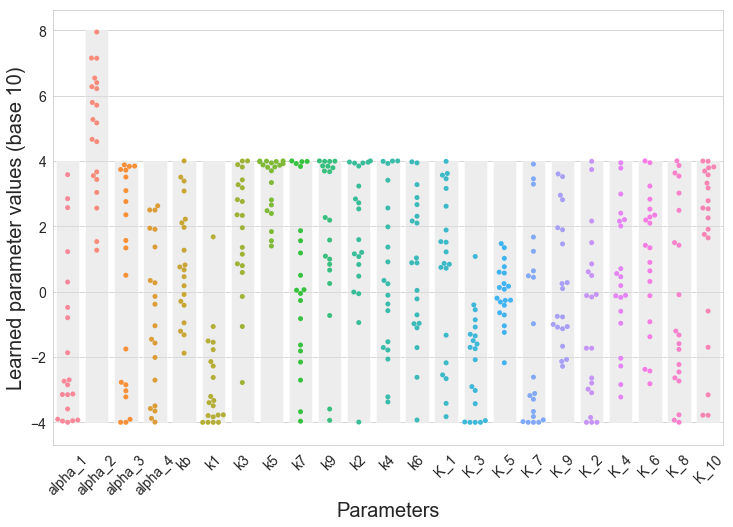

In [167]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

##  190705_WT_ptp.py -  fit to just wt and ptp23D

**Notes** 


### Inputs

In [176]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190705_WT_ptp23D/'
gen = 1000
runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
PTP = molarity_conversion(118)

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118)

# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['beta_3', 'alpha_1', 'alpha_2', 'kb', 'k1', 'k3', 'k5', 's7', 'k9', 'k2', 'k4', 'k6', 'd8', 'K_1', 'K_3', 'K_5', 'K_9', 'K_2', 'K_4', 'K_6', 'K_10'
                ]

minimums = [-4, -4, -4,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -4, -4]

maximums = [ 4, 4, 8,
    4, 4, 4, 4, 4,
    4, 4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 4, 4]

diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, X, PTP]
# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t] 
doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_doses = [150000, 550000]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly','PTP']

In [169]:
if len(labelnames) == len(diff):
    print('Params and labels match')

Params and labels match


In [174]:
def b3_a1_1D(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP

def run_wt_ss(inits, total_protein, learned_params):
    ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes

def b3_a1_1D_ramp(initials,t,total_protein,params):
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    sig = signal_ramp_special(t)

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - ((k2+beta_2*MAPK)*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((k6+alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP


def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
    learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
    #solve odes:
    odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes

def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a1_1D_ramp, inits, time, args=(total_protein, learned_params))
    return odes

def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
    return sig

In [171]:
def run_ss(inits, total_protein, learned_params):
    ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))#/total_protein*100
    return ss

### Gather simulated data

In [177]:
idx_top, top_params_a1_1D, top, plt_top, new_params, params_from_file, mse_a1_1D, last_mses_a1_1D = gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_a1_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 496.33967674579895
Mean MSE of top 5%: 578.5226923142963


### Plot

<Figure size 864x576 with 0 Axes>

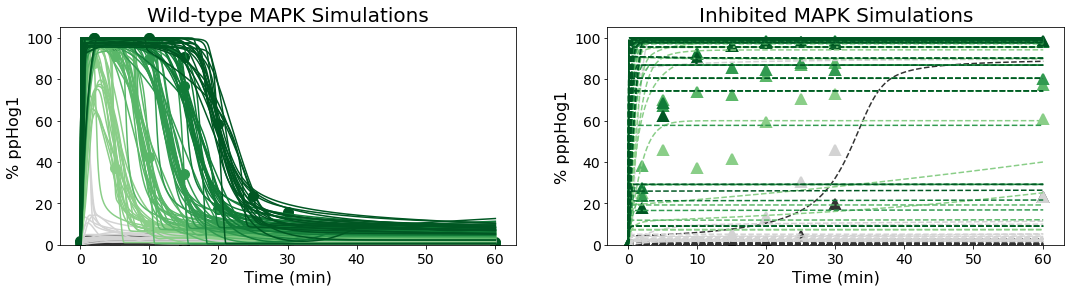

In [178]:
plt_param_behaviors(top_params_a1_1D, 20, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 864x576 with 0 Axes>

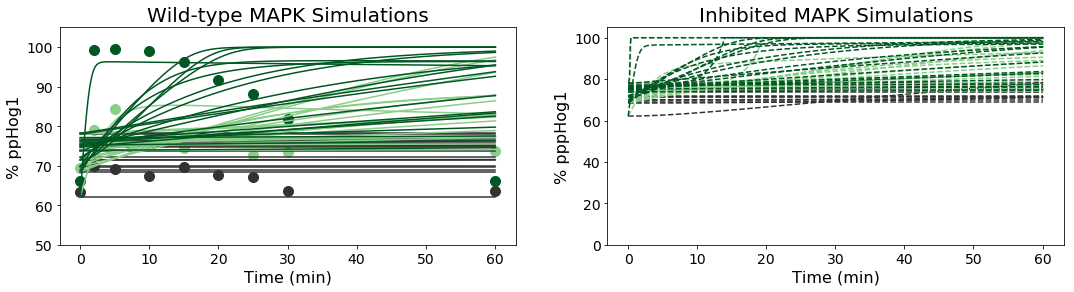

In [179]:
plt_param_behaviors(top_params_a1_1D, 20, [MAP3K_t, MAP2K_t, MAPK_t, 1, 0], initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

<Figure size 864x576 with 0 Axes>

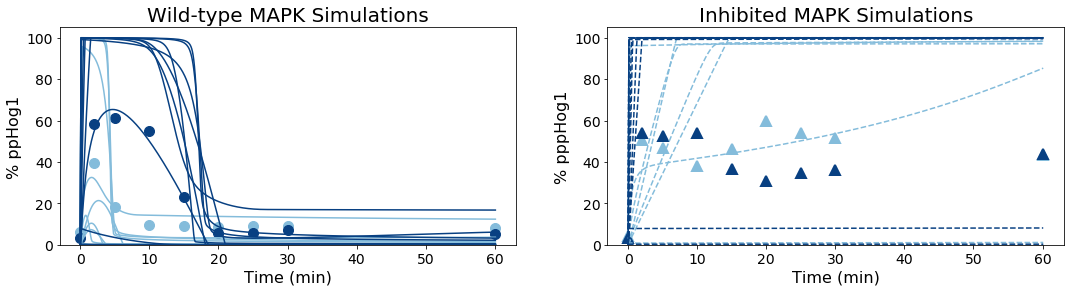

In [180]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

<Figure size 864x576 with 0 Axes>

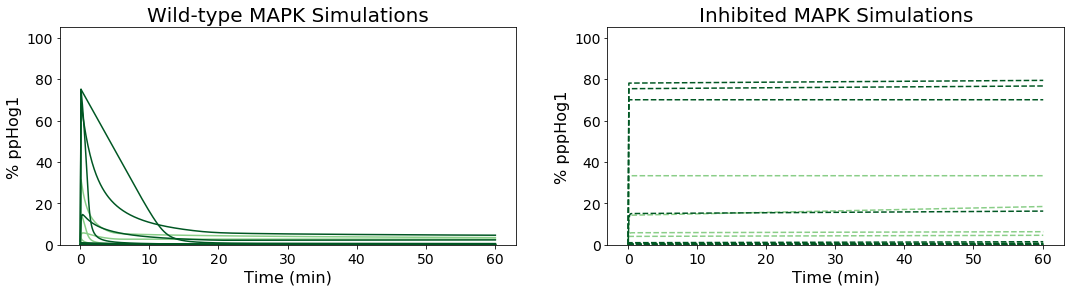

In [181]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 0)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

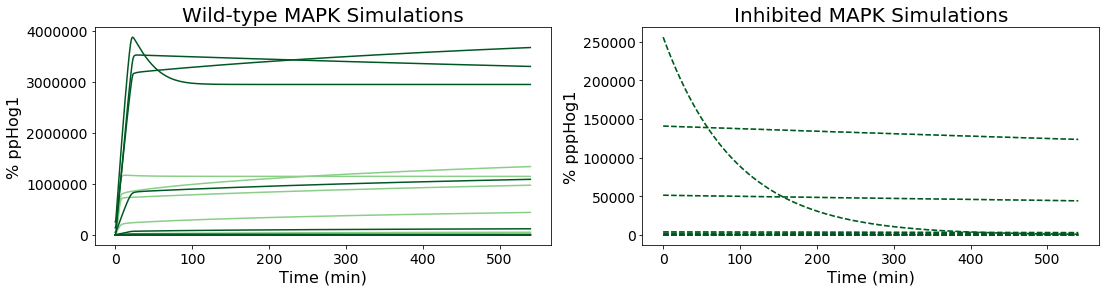

In [30]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 3)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 720x576 with 0 Axes>

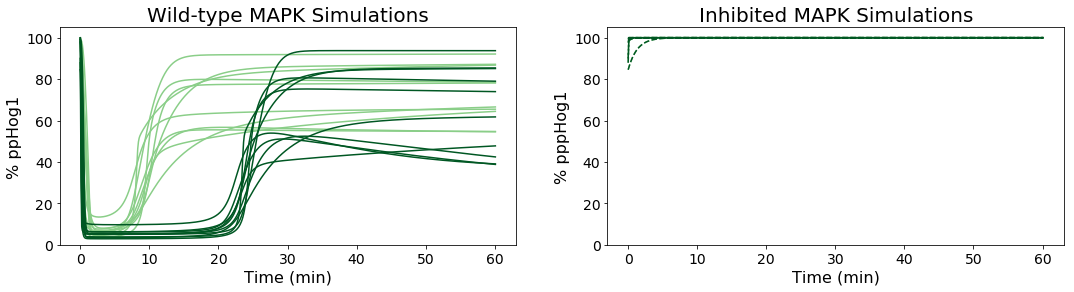

In [31]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

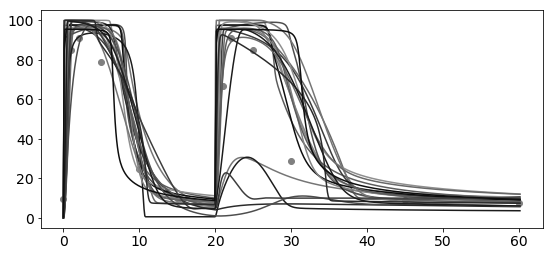

In [182]:
plt_ramp_behaviors(top_params_a1_1D, plt_top, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 864x576 with 0 Axes>

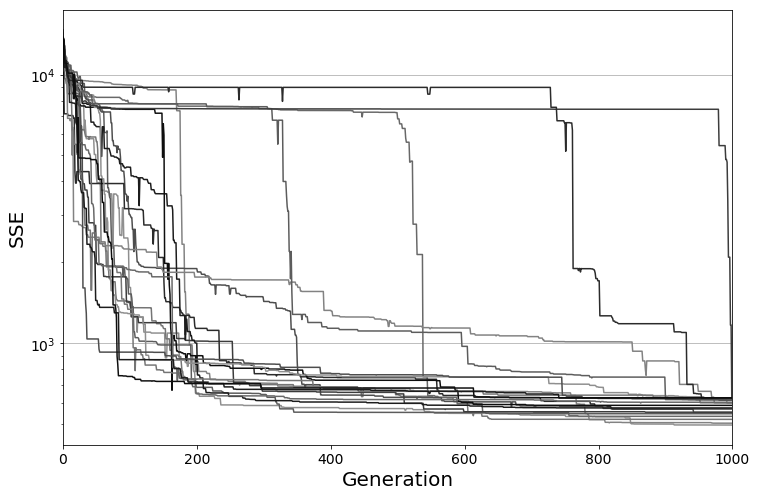

In [183]:
plt_mses_gen(gen,mse_a1_1D)

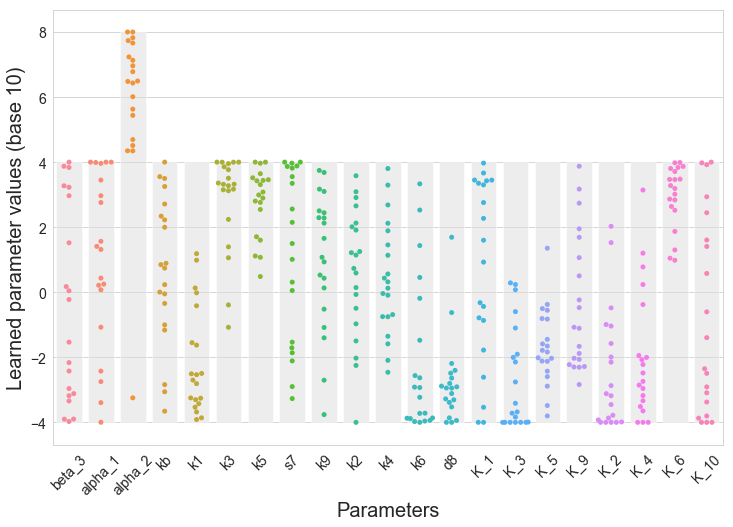

In [184]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

## 190801_kb_b3_percPTP and 190813_kb_b3_percPTP (long)

**Notes** 


### Inputs

In [56]:
# folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190801_kb_b3_percPTP/'
# gen = 1000
# doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
# map2k_doses = [150000, 550000]

folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190813_kb_b3_percPTP/'
gen = 5000
doses = [0, 50, 150, 250, 350, 450, 550]
map2k_doses = [150, 550]

runs = 2000

MAP3K = 0
MAP2K = 0
MAPK = 0
X = 0
PTP = molarity_conversion(118+400)

MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118+400)

# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['beta_3', 'alpha_1', 'alpha_2', 'kb', 'k1', 'k3', 'k5', 's7', 'k9', 'k2', 'k4', 'd8', 'K_1', 'K_3', 'K_5', 'K_9', 'K_2', 'K_4', 'K_6', 'K_10', 'p_ptp' #21

                ]

minimums = [-4, -4, -4,
    -4, -4, -4, -4, -4, -4,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -2]

maximums = [ 4, 4, 8,
    4, 4, 4, 4, 4, 4,
    4, 4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 0]


diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, X, PTP]
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t] 
# doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]

mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly','PTP']

In [41]:
if len(labelnames) == len(diff):
    print('Params and labels match')

Params and labels match


In [69]:
def b3_a1_1D(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10, _ = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes


def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10, _ = learned_params #21
    learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10, 1
    #solve odes:
    odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes

def b3_a1_1D_ramp(initials, t, total_protein, params):
    sig = signal_ramp_special(t)
    
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10, _ = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP
    

def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a1_1D_ramp, inits, time, args=(total_protein, learned_params))
    return odes

def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250
    if t_step >= 20:
        sig = 550
    return sig

In [47]:
def run_ss(inits, total_protein, learned_params):
    ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))#/total_protein*100
    return ss

# def run_t100a_ss(inits, total_protein, learned_params):
#     beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
#     learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
#     ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
#     return ss

### Gather simulated data

In [57]:
idx_top, top_params_a1_1D, top, plt_top, new_params, params_from_file, mse_a1_1D, last_mses_a1_1D = gather_simulated_data(folder, gen, runs, 0.05)
df_top_params = pd.DataFrame(top_params_a1_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 1317.058121529235
Mean MSE of top 5%: 2142.513510378673


In [49]:
df_df_top_params_all = df_top_params.copy()

### Plot

In [58]:
def gen_consts_diff(num):
    initials_diff = []
    for i in range(num):
        inits = [MAP3K_t, MAP2K_t, MAPK_t, 1, top_params_a1_1D[i][-1]*PTP_t]
        initials_diff.append(inits)
    return initials_diff

consts_diff = gen_consts_diff(50)

<Figure size 864x576 with 0 Axes>

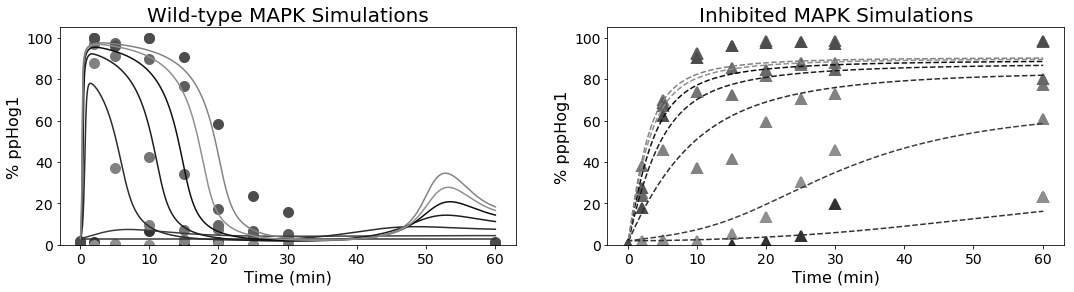

In [61]:
plt_param_behaviors(top_params_a1_1D, 1, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

<Figure size 864x576 with 0 Axes>

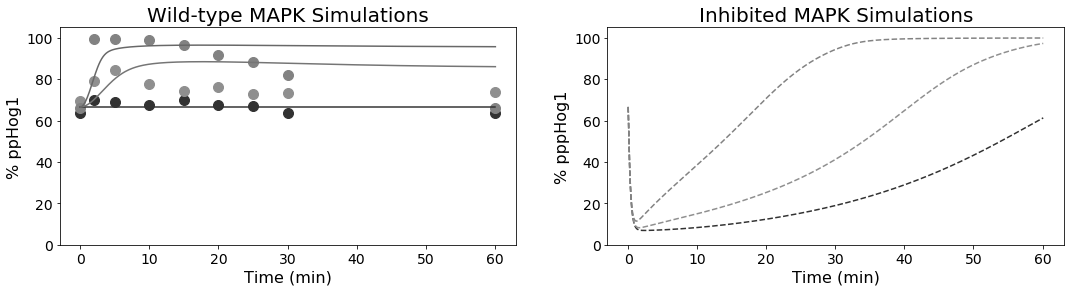

In [62]:
plt_param_behaviors_consts_diff(top_params_a1_1D, 1, consts_diff, initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 864x576 with 0 Axes>

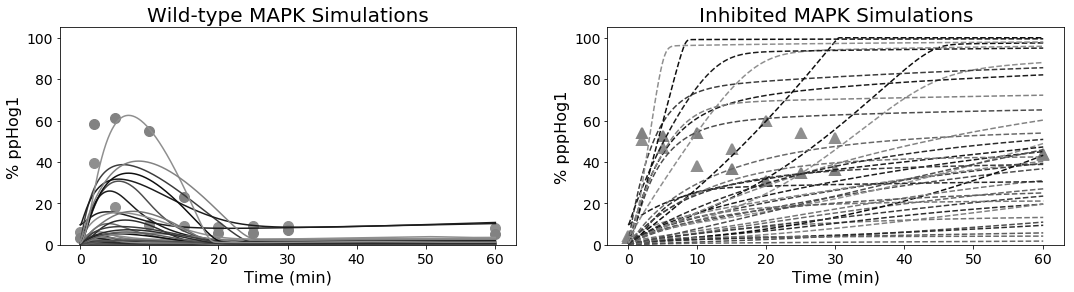

In [53]:
plt_param_behaviors(top_params_a1_1D, 20, params_constants, initials, 5000, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

<Figure size 864x576 with 0 Axes>

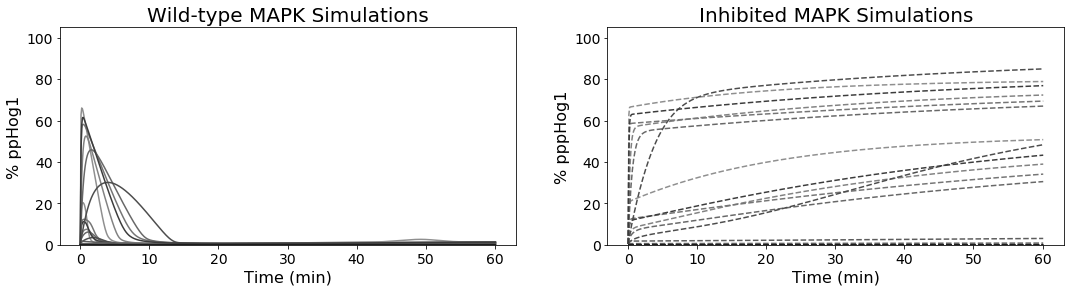

In [54]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 0)

<Figure size 864x576 with 0 Axes>

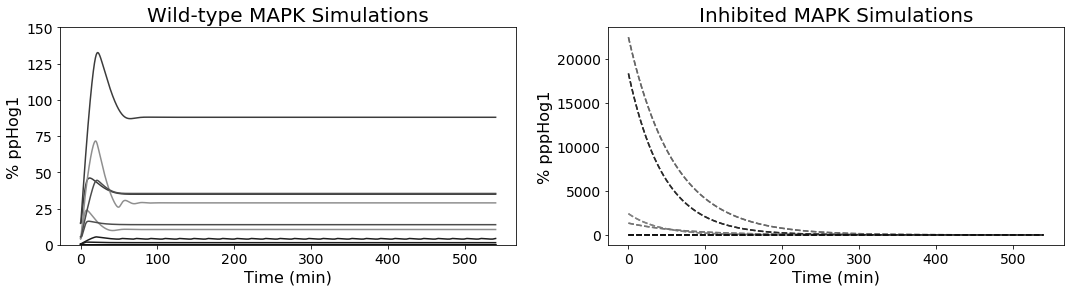

In [55]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 3)


<Figure size 864x576 with 0 Axes>

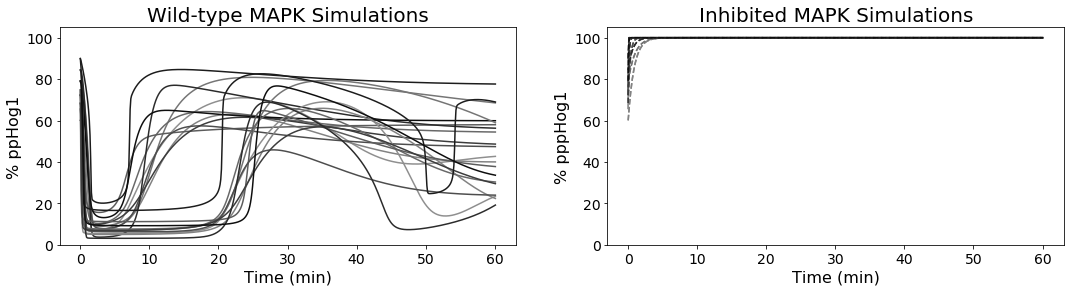

In [63]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

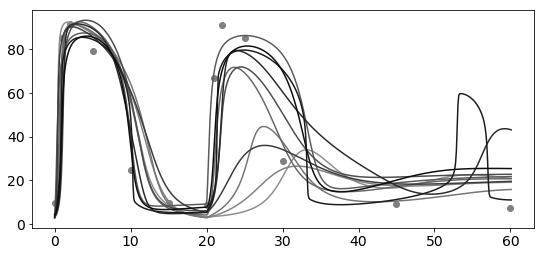

In [70]:
plt_ramp_behaviors(top_params_a1_1D, 10, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 864x576 with 0 Axes>

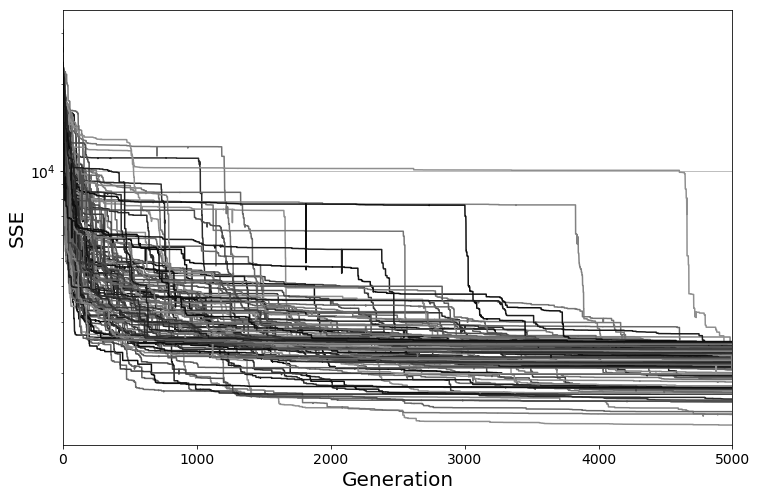

In [68]:
plt_mses_gen(gen,mse_a1_1D)

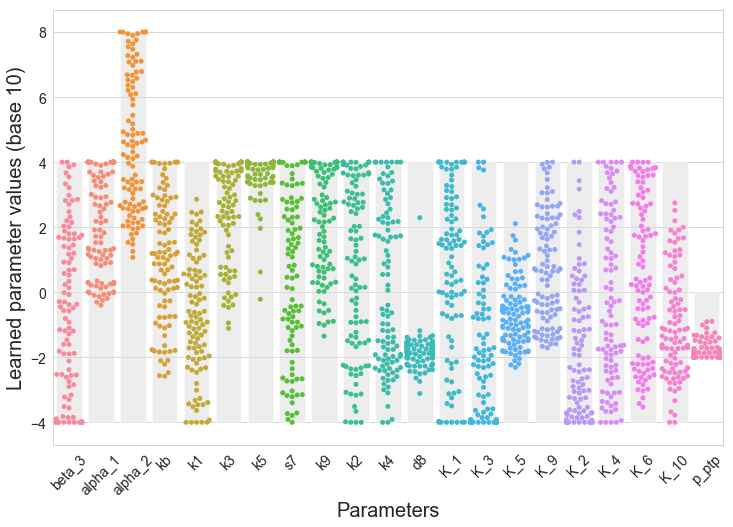

In [38]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

## 190805_kb_b3_percPTP, fit to just ptp2/3D data

**Notes** 


### Inputs

In [21]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190805_kb_b3_percPTP/'
gen = 1000
runs = 2000



MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118+400)

MAP3K = 0.05*MAP3K_t
MAP2K = 0.05975380333*MAP2K_t
MAPK = 0.00540042381*MAPK_t #0
X = 0.0001
PTP = molarity_conversion(118+400)

labelnames = ['beta_3', 'alpha_1', 'alpha_2', 'kb', 'k1', 'k3', 'k5', 's7', 'k9', 'k2', 'k4', 'd8', 'K_1', 'K_3', 'K_5', 'K_9', 'K_2', 'K_4', 'K_6', 'K_10', 'p_ptp' #21

                ]

minimums = [-4, -4, -4,
    -4, -4, -4, -4, -4, -4,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -2]

maximums = [ 4, 4, 8,
    4, 4, 4, 4, 4, 4,
    4, 4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 0]


diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, X, PTP]

# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t] 
doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_doses = [150000, 550000]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly','PTP']

In [ ]:
# mapk start % = 0.540042381
0.00540042381*MAPK_t

In [22]:
if len(labelnames) == len(diff):
    print('Params and labels match')

Params and labels match


In [ ]:
def b3_a1_1D(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10, _ = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP

def run_wt_ss(inits, total_protein, learned_params):
    ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes


def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10, _ = learned_params #21
    learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10, 1
    #solve odes:
    odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes

def b3_a1_1D_ramp(initials, t, total_protein, params):
    sig = signal_ramp_special(t)
    
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10, _ = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP
    
    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP

def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a1_1D_ramp, inits, time, args=(total_protein, learned_params))
    return odes

def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
    return sig

In [23]:
def run_ss(inits, total_protein, learned_params):
    ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))#/total_protein*100
    return ss

# def run_t100a_ss(inits, total_protein, learned_params):
#     beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
#     learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
#     ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
#     return ss

### Gather simulated data

In [17]:
idx_top, top_params_a1_1D, top, plt_top, new_params, params_from_file, mse_a1_1D, last_mses_a1_1D = gather_simulated_data(folder, gen, runs, 0.01)
df_top_params = pd.DataFrame(top_params_a1_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 17.4217805445898
Mean MSE of top 5%: 28.94607010154055


In [21]:
scorefxn(initials, params_constants, top_params_a1_1D[0])

NameError: name 'scorefxn' is not defined

In [32]:
df_top_params_ptp23 = df_top_params.copy()

In [228]:
df_top_params_ptp23

beta_3      alpha_1       alpha_2           kb        k1  \
0      0.000633  8411.949981  1.949694e+05  9083.122596  0.000207   
1      0.000100     0.016040  1.000536e-04  2223.756130  0.000136   
2    759.648621     4.352923  1.000000e-04  3025.249125  0.000439   
3      0.000100     0.146222  1.000003e-04   540.291914  0.000114   
4   8259.550031    74.059029  7.630301e-03  8205.119328  0.000827   
5      0.000144     0.561470  1.000000e-04   771.907487  0.000172   
6   4645.085346    19.756363  1.609100e+06   659.820567  0.000100   
7      0.000122     0.005864  1.305678e+03   473.323060  0.000125   
8      0.004283     0.003127  6.543366e-03   382.390190  0.000163   
9   9111.290810    15.126473  1.000001e-04  7285.803205  0.001474   
10     0.087078    81.987141  1.399390e+05  4754.650219  0.001637   
11    10.112772     0.006399  1.000003e-04   283.715947  0.000122   
12     0.073703     4.027216  1.000000e-04  2916.073795  0.001264   
13     0.136258     0.000861  6.506927e+00  2699.789597  0.000604   
14     0.201995     0.000632  1.293771e+05    53.679993  0.000100   
15     0.000407     4.142420  1.329341e+04   342.207843  0.000128   
16     0.000155     0.125791  2.364280e-04  9999.999152  0.004388   
17     0.017507     0.000125  8.145846e+00   517.468782  0.000742   
18     0.014839     0.003167  1.099044e+06  8713.485944  0.004210   
19     0.001537     0.000229  1.958278e+03   604.359617  0.000100   

              k3           k5           s7           k9           k2  \
0     180.311916  1168.970806     0.000370  2007.330937     0.044927   
1    6884.044956  9999.999937     0.000100     0.002449    20.430710   
2       8.427423  8712.879871  3990.545962     0.579823     2.198555   
3     858.637608  1782.693795     0.014202     0.022736    11.014755   
4    5539.492743  9993.807506  9406.565766    11.262378  6419.961388   
5    9013.121483     9.985135     0.001694     0.086753   238.928438   
6    6242.512997  1295.479340  1219.219430    28.449406   124.380814   
7    2729.589240     0.001013     0.000120     0.876136  1144.557641   
8    9163.114877  6810.898911    84.475801     0.000848  4222.715079   
9    7691.150547  9999.788002  9841.077558     2.355966    77.249750   
10    409.091212  9999.999973     0.080457     0.034001    25.736522   
11      6.298407   373.353607   488.320604     0.000972  8712.730898   
12    714.624402     5.470677    13.547887     0.613396     0.103665   
13      0.003087   907.280470     1.598184     0.008402   923.247883   
14   1104.664064  6774.986361    33.713389     0.002936     1.330688   
15  10000.000000  3208.074969     9.839143     0.076111    58.921484   
16   9875.033965  1179.714635     3.347263     0.018675     0.066801   
17   9999.999740    21.318421   959.520416     0.152012     6.528458   
18   3133.742829   247.377263    20.746652     0.580253     0.003189   
19   7211.050654   511.905361     0.006521  9653.524468    57.112604   

      ...            d8          K_1         K_3        K_5          K_9  \
0     ...      0.000861   101.979303    0.043138   0.000737  3106.288494   
1     ...      0.002660  1555.570591    0.000100   0.000100     0.000101   
2     ...      0.006735     0.304658    0.000864   0.000598     0.000222   
3     ...      0.010385     2.883867    0.000247   0.000128     0.000104   
4     ...      0.004918     0.018010    0.032481   0.000100     0.000168   
5     ...      0.010242     0.001348    0.000100   0.000100     0.000101   
6     ...      0.007734     0.006430    8.688899   0.041130     0.063607   
7     ...      0.016533     0.000100    0.000101   0.002557    86.756147   
8     ...      0.020781     0.008708    1.268721   0.000709     0.003440   
9     ...      0.012175     3.100421  134.516950   0.000100     0.000145   
10    ...      0.014676     0.449371    0.000231  28.254035     0.018655   
11    ...      0.019848     0.013660    0.000100   0.000182     0.000117   
12    ...      0.023011     0.747067    0.059538   0.00075

### Plot

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 720x576 with 0 Axes>

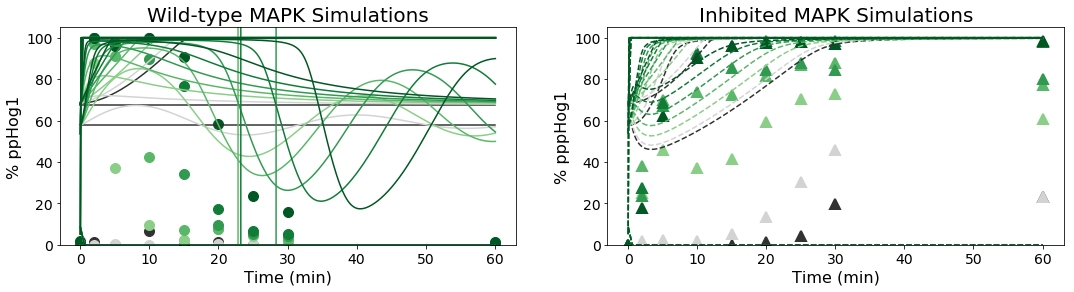

In [24]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

In [529]:
def gen_consts_diff(num):
    initials_diff = []
    for i in range(num):
        inits = [MAP3K_t, MAP2K_t, MAPK_t, 1, top_params_a1_1D[i][-1]*PTP_t]
        initials_diff.append(inits)
    return initials_diff

consts_diff = gen_consts_diff(10)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<Figure size 432x288 with 0 Axes>

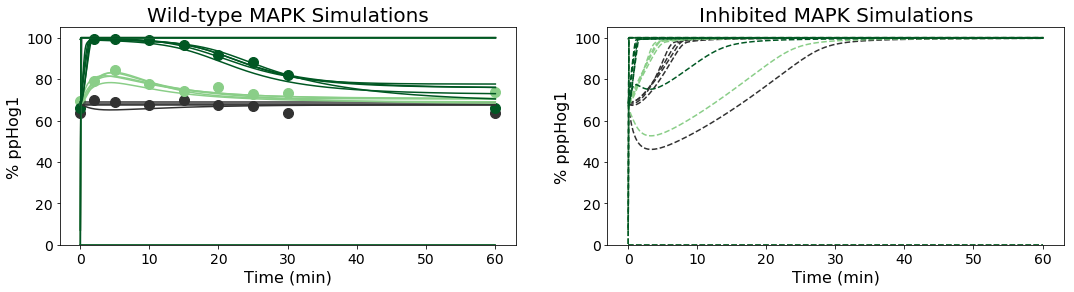

In [530]:
plt_param_behaviors_consts_diff(top_params_a1_1D, 10, consts_diff, initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

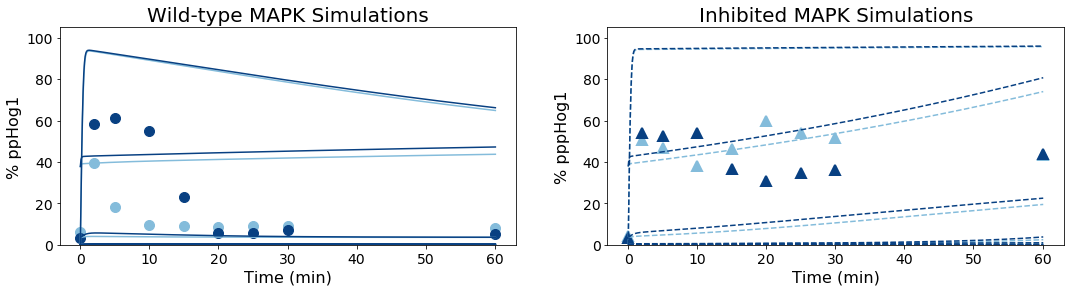

In [532]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

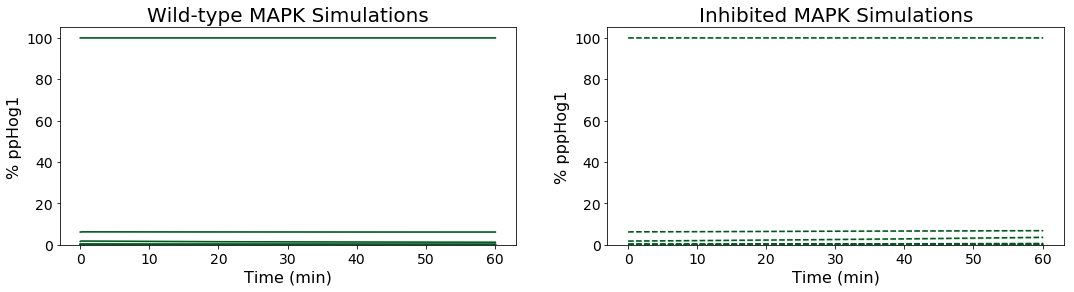

In [533]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 0)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

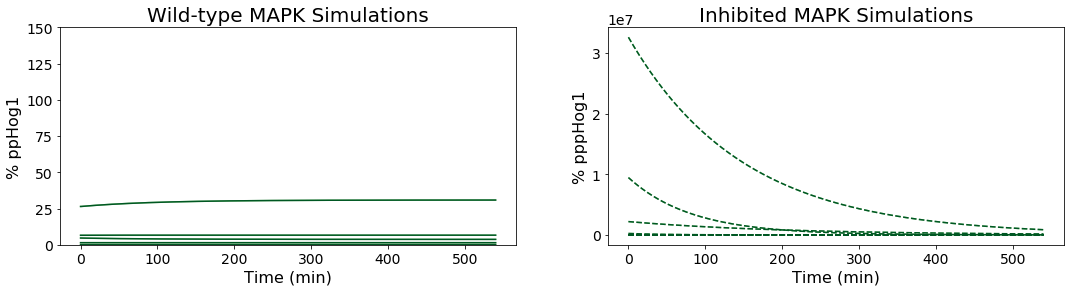

In [534]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 3)


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1200.
  warnings.warn(msg, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

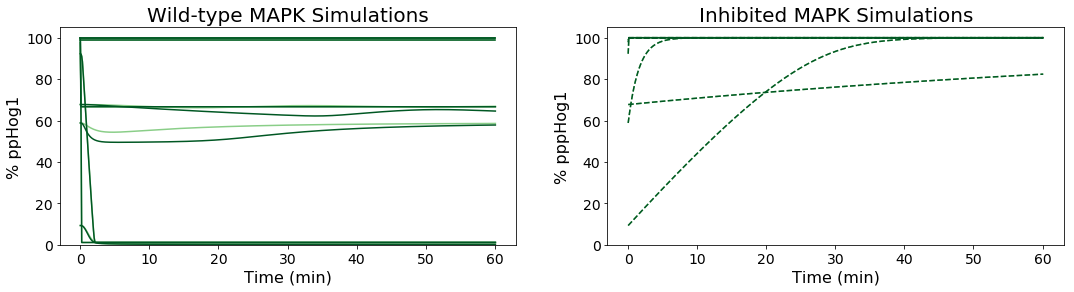

In [535]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

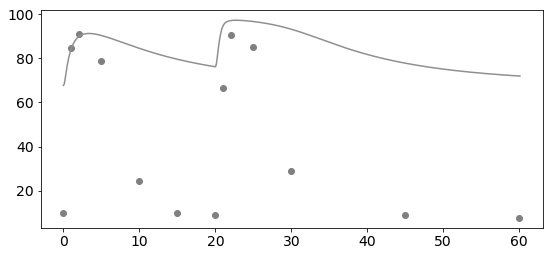

In [538]:
plt_ramp_behaviors(top_params_a1_1D, 1, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 864x576 with 0 Axes>

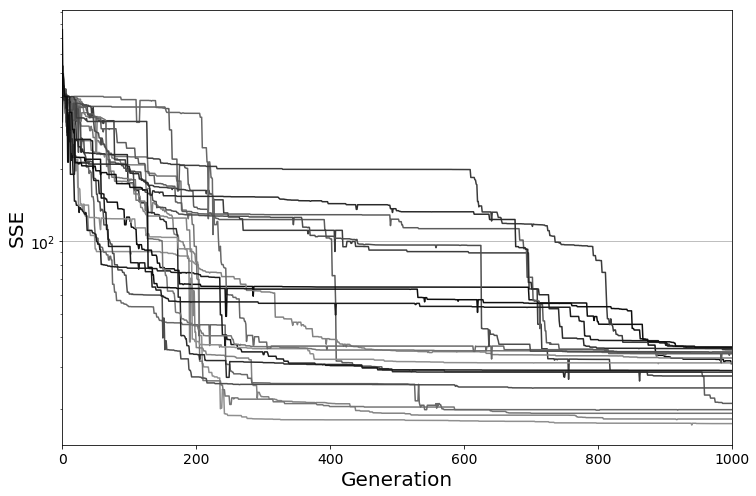

In [27]:
plt_mses_gen(gen,mse_a1_1D)

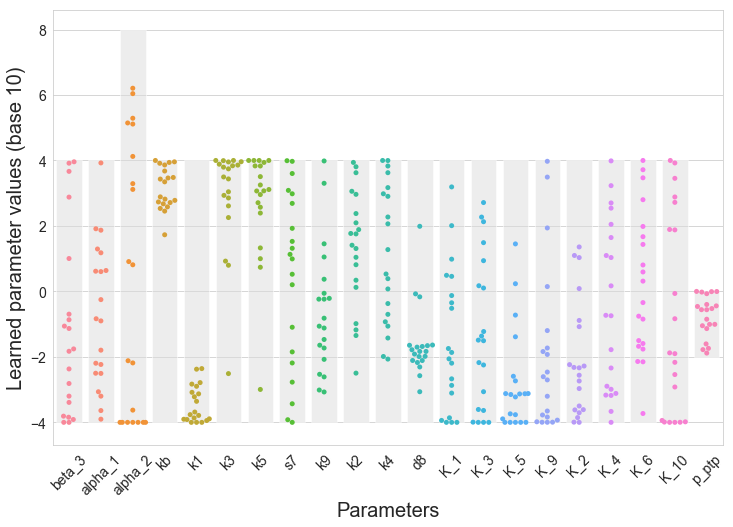

In [26]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

## 190806_kb_b3_percPTP_long, fit to all, 5000 gen

**Notes** 


### Inputs

In [71]:
folder = 'C:/Users/sksuzuki/Desktop/killdevil/from/fit_to_ramp/190806_kb_b3_percPTP_long/'
gen = 5000
runs = 2000



MAP3K_t = molarity_conversion(701)
MAP2K_t = molarity_conversion(2282)
MAPK_t = molarity_conversion(5984)
PTP_t = molarity_conversion(118+400)

MAP3K = 0.05*MAP3K_t
MAP2K = 0.05975380333*MAP2K_t
MAPK = 0.00540042381*MAPK_t #0
X = 0
PTP = molarity_conversion(118+400)

# s = [0, 50000, 150000, 250000, 350000, 450000, 550000]


labelnames = ['beta_3', 'alpha_1', 'alpha_2', 'kb', 'k1', 'k3', 'k5', 's7', 'k9', 'k2', 'k4', 'd8', 'K_1', 'K_3', 'K_5', 'K_9', 'K_2', 'K_4', 'K_6', 'K_10', 'p_ptp' #21

                ]

minimums = [-4, -4, -4,
    -4, -4, -4, -4, -4, -4,
    -4, -4, -4, -4, -4,
    -4, -4, -4, -4,
    -4, -4, -2]

maximums = [ 4, 4, 8,
    4, 4, 4, 4, 4, 4,
    4, 4, 4, 4, 4,
    4, 4, 4, 4,
    4, 4, 0]


diff = np.asarray(maximums)-np.asarray(minimums)

# fb = 1
# t100a_fb = 0

initials = [MAP3K, MAP2K, MAPK, X, PTP]

# params_constants = [MAP3K_t, MAP2K_t, MAPK_t, PTP_t] 
params_constants = [MAP3K_t, MAP2K_t, MAPK_t, 1, PTP_t] 
doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
map2k_doses = [150000, 550000]
ptp_doses = [0, 150000, 550000]
mapk_time_t100a_long = [0, 2, 5, 10, 15, 20, 25, 30, 60, 90, 120, 150, 180, 240, 300]

labels = ['MAP3K','MAP2K','MAPK','gly','PTP']

In [ ]:
# mapk start % = 0.540042381
0.00540042381*MAPK_t

In [72]:
if len(labelnames) == len(diff):
    print('Params and labels match')

Params and labels match


In [73]:
def b3_a1_1D(initials,t,total_protein,sig,params):
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10, _ = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP

def run_wt_ss(inits, total_protein, learned_params):
    ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
    return ss

def simulate_wt_experiment(inits, total_protein, sig, learned_params, time):
    odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes


def simulate_t100a_experiment(inits, total_protein, sig, learned_params, time):
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10, _ = learned_params #21
    learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10, 1
    #solve odes:
    odes = odeint(b3_a1_1D, inits, time, args=(total_protein, sig, learned_params))
    return odes

def b3_a1_1D_ramp(initials, t, total_protein, params):
    sig = signal_ramp_special(t)
    
    MAP3K, MAP2K, MAPK, gly, PTP = initials
    MAP3K_t, MAP2K_t, MAPK_t, _, PTP_t = total_protein
    beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10, _ = params #21

    MAP3K_I = MAP3K_t-MAP3K
    MAP2K_I = MAP2K_t-MAP2K
    MAPK_I = MAPK_t-MAPK
    PTP_I = PTP_t-PTP

    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP
    
    dMAP3K = (((sig*k1+kb)/(1+gly/beta_3))*MAP3K_I)/(K_1+MAP3K_I) - (k2*MAP3K/(K_2+MAP3K))
    dMAP2K = (((k3*MAP3K)*MAP2K_I)/(K_3+MAP2K_I)) - (k4*MAP2K/(K_4+MAP2K))
    dMAPK = (((k5*MAP2K)*MAPK_I)/(K_5+MAPK_I)) - ((alpha_2*PTP)*MAPK)/(K_6+MAPK)
    dgly = s7*MAPK - d8*gly
    dPTP = (k9*PTP_I/(K_9+PTP_I)) - ((alpha_1*MAPK)*PTP)/(K_10+PTP)

    return dMAP3K, dMAP2K, dMAPK, dgly, dPTP

def simulate_ramp_experiment(inits, total_protein, learned_params, time):
    # parameters to be learned - inits
    # parameters to be kept constant - params_constants
    # parameters to be learned - learned_params

    #solve odes:
    odes = odeint(b3_a1_1D_ramp, inits, time, args=(total_protein, learned_params))
    return odes

def signal_ramp_special(t_step):
    sig = 0
    if t_step >= .001:
        sig = 250000
    if t_step >= 20:
        sig = 550000
    return sig

In [74]:
def run_ss(inits, total_protein, learned_params):
    ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))#/total_protein*100
    return ss

# def run_t100a_ss(inits, total_protein, learned_params):
#     beta_3, alpha_1, alpha_2, kb, k1, k3, k5, s7, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10 = learned_params #21
#     learned_params = beta_3, 0, alpha_2, kb, k1, k3, k5, 0, k9, k2, k4, k6, d8, K_1, K_3, K_5, K_9, K_2, K_4, K_6, K_10
#     ss = fsolve(b3_a1_1D, inits, args=(0,total_protein, 0, learned_params))
#     return ss

### Gather simulated data

In [81]:
idx_top, top_params_a1_1D, top, plt_top, new_params, params_from_file, mse_a1_1D, last_mses_a1_1D = gather_simulated_data(folder, gen, runs, 0.05)
df_top_params = pd.DataFrame(top_params_a1_1D)
df_top_params.columns = labelnames
df_top_params_log = df_top_params.apply(np.log10)
df_top_params_log_M = df_top_params_log.melt(var_name='param', value_name='vals')

Best MSE: 2760.998335195165
Mean MSE of top 5%: 3796.710800570014


In [82]:
scorefxn(initials, params_constants, top_params_a1_1D[0])

[731.9887984877017,
 1144.4791345573435,
 313.7658326165055,
 279.9530017138598,
 2149.4032783070884,
 632.8545678725117]

In [88]:
df_top_params_all = df_top_params.copy()

In [89]:
df_top_params_all

beta_3       alpha_1       alpha_2            kb           k1  \
0      0.000145   3330.357195  6.112356e+01     28.374707     0.002110   
1      6.234425      0.277736  5.621889e+04     14.436218     0.000100   
2      0.000402      0.022029  5.797213e+05      3.634242     0.656769   
3      2.150878      0.480662  6.150922e+00     51.741802     0.010533   
4      0.293633    455.363103  7.663360e+07   1731.426559     0.090819   
5   1366.742287      0.046300  4.470456e+06      3.028664     0.000228   
6   1438.002480      0.061749  2.467979e+02   9806.389985  2710.769170   
7      0.011430  10000.000000  9.160286e+04     11.728084     0.000101   
8      7.222850      3.321043  3.713080e+02    599.025948     0.050405   
9      0.000129   9321.037478  1.790279e+02     44.360375     0.000479   
10     3.357555   9927.669932  1.322208e+01  10000.000000     0.449015   
11    15.708974      0.373835  2.489404e+02      8.499156     0.000101   
12    23.801784      0.011550  8.896884e+00   5675.815381     0.407544   
13   153.324135      0.040114  1.633445e+07      0.416696     0.000105   
14   541.752581    346.416720  3.112331e+03  10000.000000     0.064033   
15  4315.156996      1.385443  1.184728e+02     20.934350     0.000219   
16    22.480752  10000.000000  5.201903e+01    106.145433     0.003336   
17   336.293712  10000.000000  4.536530e+01      8.850235     0.000670   
18     0.000102      1.468931  7.396218e+01   4245.847331     0.072900   
19     0.000100      0.003127  7.048873e+01      1.787828     0.033300   
20  9230.899952      0.035990  4.211289e+03     12.302963     0.000106   
21    90.257115   5206.731996  3.253675e+00     80.336423     0.001631   
22    18.260781   9999.999858  3.384705e+03      0.824029     0.000100   
23     0.000100      6.594538  5.442278e+02      0.905505     0.000100   
24     0.000100  10000.000000  1.181864e+04      3.395982     0.000106   
25     0.001878     61.709426  2.781523e+01     14.182249     0.001861   
26    76.714243     15.961615  7.512144e+04   1993.831958     0.005875   
27     0.064567      3.101548  5.998124e+02    440.614078     0.006625   
28     0.000115      0.216665  9.130850e+06     38.883227     0.000265   
29    19.456299    135.717398  3.291634e+02    355.774490     0.004819   
..          ...           ...           ...           ...          ...   
70     0.000111      7.379459  3.481074e+02    289.673250     0.005340   
71  5232.931425    181.446429  3.554072e+02      5.339757     0.000102   
72     0.001107      1.773393  1.642313e+06   1119.825164     0.036127   
73   438.816979      0.021027  1.941363e+01     92.537279     0.003291   
74     0.525303     22.574730  8.756700e+02      8.678055     0.000102   
75     0.061314     25.419180  1.928549e+02    258.382248     0.042863   
76     0.019379      0.243009  4.199746e+01   3227.030386     2.374940   
77     0.001484      0.060654  1.275748e+05      3.184567     0.000100   
78     0.000100     14.054870  1.597619e+02     32.444891     0.002097   
79     0.010361    691.972095  1.343464e+02     78.039151     0.006234   
80     4.232377      0.000525  1.404718e+02   1745.616059     0.036602   
81     0.001244   6943.793379  6.045735e+02  10000.000000     0.229969   
82     0.025447   7568.572778  2.628907e+01      1.403351     0.000100   
83     0.000100    255.015369  3.390978e+06   2130.687290     0.044283   
84     0.022049      0.147097  3.185885e+02      9.042552     0.000296   
85     7.146437   1089.343896  8.094561e+00     26.030188     0.000125   
86     1.580655      0.914630  1.512840e+02      1.035778     0.000100   
87     0.866556      0.046674  1.560488e+01      0.003010     0.000100   
88     0.000146      0.814813  9.981444e+01    767.104123     0.017444   
89  3860.704421    351.844803  5.572817e+01    123.674570     0.001591   
90   865.129256   1529.836550  3.585961e+05     12.723735     0.000931   
91     0.259415   7316.345890  1.121820e+01      4.649616     0.000100   
92     0.1556

### Plot

<Figure size 864x576 with 0 Axes>

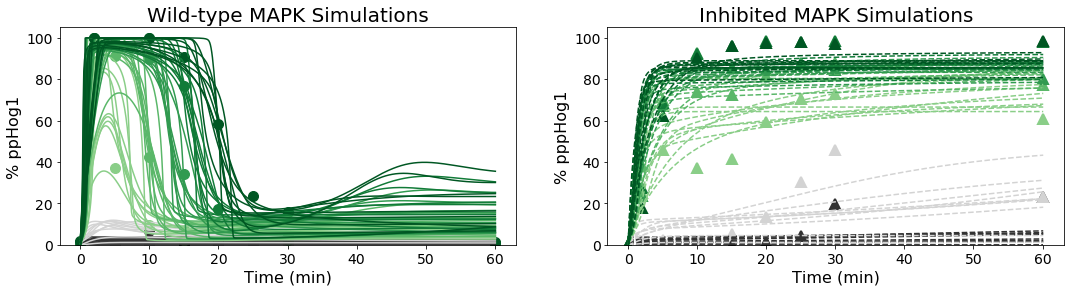

In [83]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)
# plt.savefig("C:/Users/sksuzuki/Documents/Research/figures/simulations/hog1.png",dpi=150,bbox_inches='tight')

In [84]:
def gen_consts_diff(num):
    initials_diff = []
    for i in range(num):
        inits = [MAP3K_t, MAP2K_t, MAPK_t, 1, top_params_a1_1D[i][-1]*PTP_t]
        initials_diff.append(inits)
    return initials_diff

consts_diff = gen_consts_diff(10)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


<Figure size 864x576 with 0 Axes>

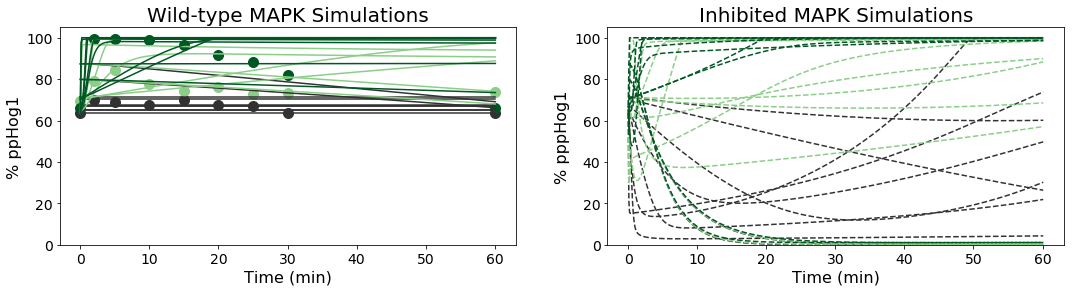

In [85]:
plt_param_behaviors_consts_diff(top_params_a1_1D, 10, consts_diff, initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

<Figure size 864x576 with 0 Axes>

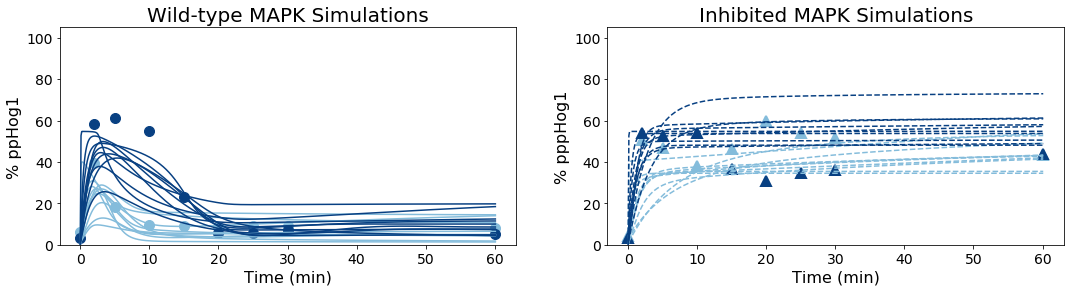

In [86]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 1, map2k_wt_data, map2k_t100a_data, mapk_time)

<Figure size 720x576 with 0 Axes>

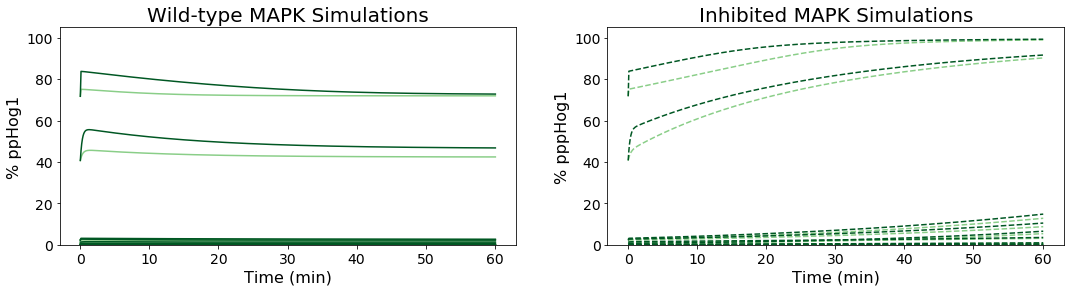

In [26]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 0)

<Figure size 720x576 with 0 Axes>

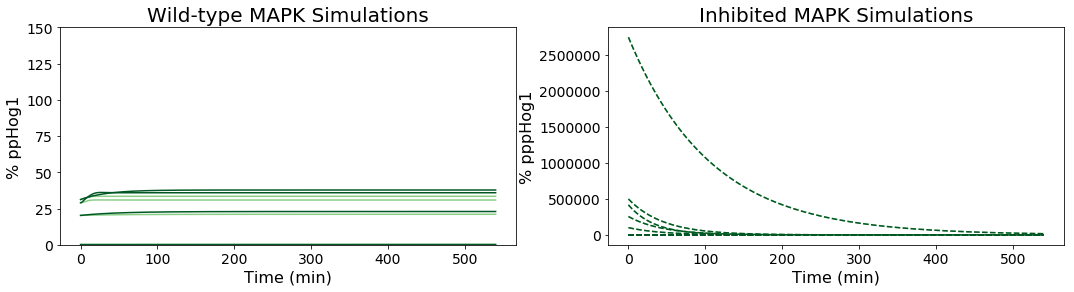

In [27]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 3)


<Figure size 720x576 with 0 Axes>

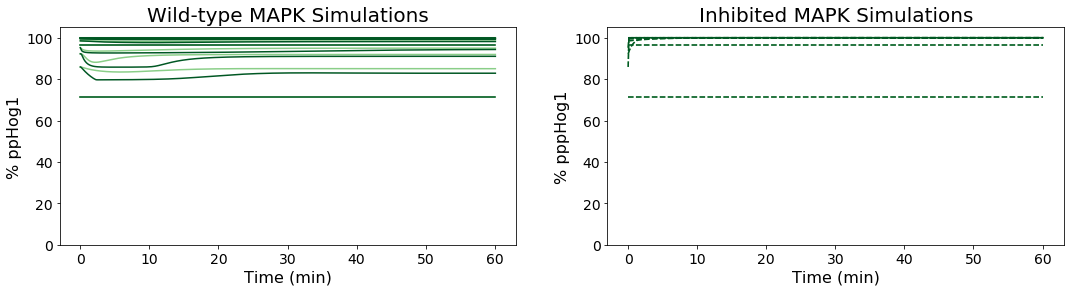

In [28]:
plt_param_behaviors(top_params_a1_1D, 10, params_constants, initials, 5000, map2k_doses, time, 4)

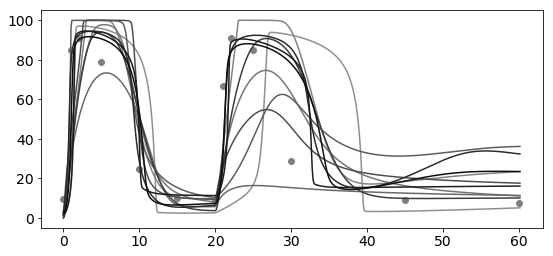

In [87]:
plt_ramp_behaviors(top_params_a1_1D, 10, params_constants, initials, gen, time, 2, hog1_ramp_data, mapk_ramp_time)

<Figure size 864x576 with 0 Axes>

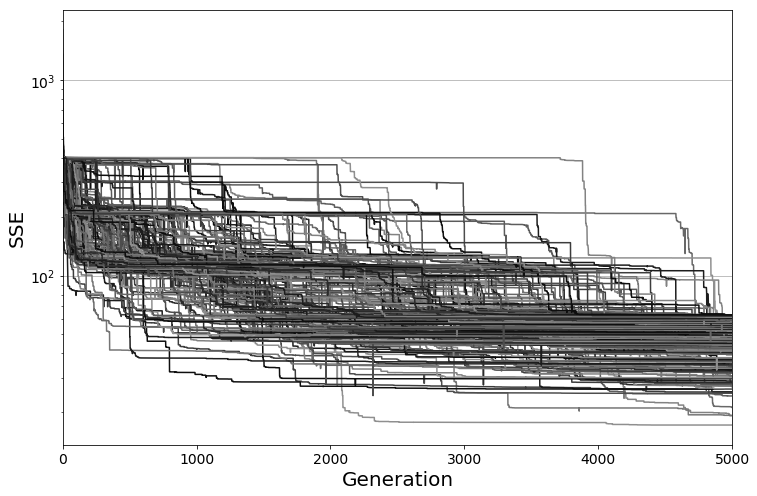

In [68]:
plt_mses_gen(gen,mse_a1_1D)

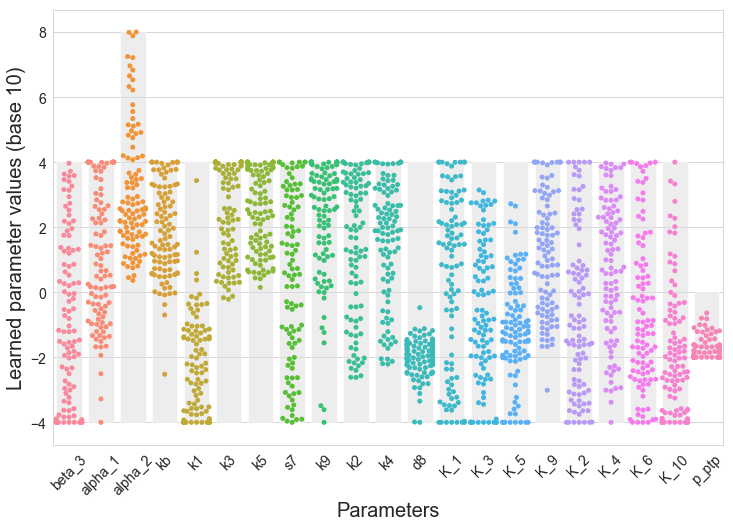

In [90]:
    # positive 3db7d6
    # negative ee9537
    # hog1 ? 38bf85 or 94ddaa

colors = ['#3c3c3c','#3c3c3c'] #+ rocket[::-1][:4] + rocket[::-1][:4]+ rocket[::-1][:3]+ rocket[::-1][:3]

plot_param_ranges(labelnames, diff, minimums, df_top_params_log_M)

# Compare models

## Assess parameter space

In [158]:
best_fit = top_params_a1_1D[0].copy()
best_fit

[0.0006328370014249666,
 8411.94998094207,
 194969.3611864842,
 9083.122596160052,
 0.00020665934450005293,
 180.31191588674275,
 1168.9708060113849,
 0.00036961134050459733,
 2007.3309369545398,
 0.04492665564243325,
 0.19933738292603168,
 0.0008612421930380466,
 101.97930325211492,
 0.043138318696052516,
 0.0007374908022939019,
 3106.2884939909836,
 0.0018355452457365742,
 0.00010013699562135449,
 96.38453387916549,
 2846.1431872918183,
 0.99999999958208]

In [163]:
def change_param(param_set, idx):
    param_sets = []
#     print(param_set[idx])
    for i in np.logspace(-4,4,8):
        new_param_set = param_set.copy()
#         print(i)
#         print(new_param_set[idx])
        new_param_set[idx] = new_param_set[idx]*i
#         print(new_param_set[idx])
        param_sets.append(new_param_set)
    return param_sets

In [165]:
b3 = change_param(best_fit, 0)
a1 = change_param(best_fit, 1)
a2 = change_param(best_fit, 2)
kb = change_param(best_fit, 3)
k1 = change_param(best_fit, 4)
k3 = change_param(best_fit, 5)
k5 = change_param(best_fit, 6)
s7 = change_param(best_fit, 7)
k9 = change_param(best_fit, 8)
k2 = change_param(best_fit, 9)
k4 = change_param(best_fit, 10)
d8 = change_param(best_fit, 11)
K1 = change_param(best_fit, 12)
K3 = change_param(best_fit, 13)
K5 = change_param(best_fit, 14)
K9 = change_param(best_fit, 15)
K2 = change_param(best_fit, 16)
K4 = change_param(best_fit, 17)
K6 = change_param(best_fit, 18)
K10 = change_param(best_fit, 19)
pPTP= change_param(best_fit, 20)

<Figure size 864x576 with 0 Axes>

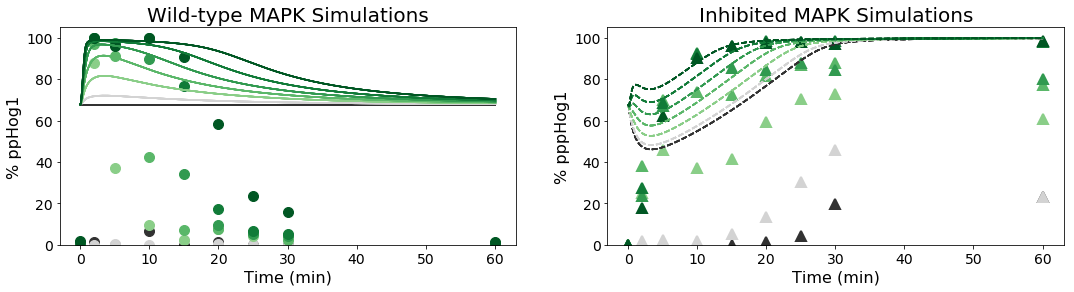

In [256]:
plt_param_behaviors(pPTP, 10, params_constants, initials, 5000, doses, time, 2, mapk_wt_data, mapk_t100a_data, mapk_time)

<Figure size 864x576 with 0 Axes>

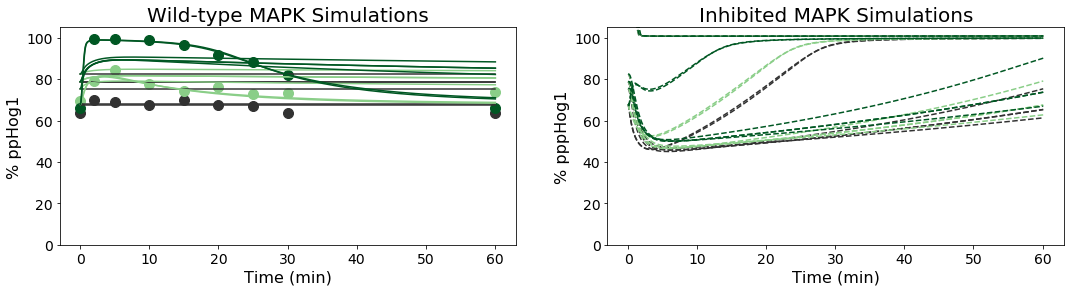

In [257]:
plt_param_behaviors_consts_diff(pPTP, 10, consts_diff, initials, 5000, [0]+map2k_doses, time, 2, mapk_ptp_data, None, mapk_time)

## Calculate Ttest

In [39]:
from scipy.stats import ttest_ind
ttest = ttest_ind(df_top_params_ptp23, df_df_top_params_all, axis=0)
print(ttest)

Ttest_indResult(statistic=array([ 2.39679427, -2.79229073, -1.32267715,  1.35465514, -0.54118825,
        1.7618635 , -1.96711273, -0.65253951, -2.92496233, -1.32407551,
        1.11084685,  3.27659218, -2.54644332, -0.51225341, -0.5430844 ,
       -0.64036423, -0.88305972, -0.81891478, -0.58938274,  5.35936213,
       13.22090904]), pvalue=array([1.73831097e-02, 5.69868390e-03, 1.87328616e-01, 1.76929721e-01,
       5.88930435e-01, 7.94939813e-02, 5.04386338e-02, 5.14740687e-01,
       3.80914011e-03, 1.86864583e-01, 2.67857974e-01, 1.22241783e-03,
       1.15725799e-02, 6.08992243e-01, 5.87626541e-01, 5.22608326e-01,
       3.78176751e-01, 4.13729348e-01, 5.56214849e-01, 2.11972735e-07,
       1.08039792e-29]))


Tukey's test (honing in on two comparisons of the group) for ANOVA (summary statistic comparing all of the groups) correcting for multiple testing https://cleverowl.uk/2015/07/01/using-one-way-anova-and-tukeys-test-to-compare-data-sets/

## Calculate score

In [290]:
hog1_doses = [0, 50000, 150000, 250000, 350000, 450000, 550000]
pbs2_doses = [150000, 550000]
ptp_doses = [0, 150000, 550000]

for params in top_params_a1_1D[:10]:
    print(scorefxn(initials, params_constants, params))

[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0, 2, 5, 10, 15, 20, 25, 30, 60]
[0.0, 0.0, 0.0, 0.0, 0.0, 1.361472, 4.18506, 19.49207995, 23.08120093, 23.78618578, 22.3375094, 31.67199502, 36.30961501, 33.02963546, 34.87627365]


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


ValueError: operands could not be broadcast together with shapes (9,) (15,) 